In [1]:
#gneral libraries
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import random as rn

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Image processing libraries
import cv2
from PIL import Image
from PIL import ImageOps


import struct #binary format hanling library
import xml.etree.ElementTree as ET #xml handling library

import warnings
warnings.filterwarnings("ignore")

## Augmneting the Image data

In [11]:
import tensorflow as tf
from imgaug import augmenters as iaa

In [12]:
#augumentation techniques
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

## Creating a Dataloader i.e. Input Data stream for Training

In [13]:
class Dataset:
    '''Reads Input image and preprocess them and returns along with both table and column masks'''
    def __init__(self, df, augmentation=False):
        self.df = df
        self.augmentation = augmentation

        #path of Images
        self.image_path = self.df['image_path'].to_list()
        self.tmask_path = self.df['table_mask_path'].to_list()
        self.cmask_path = self.df['col_mask_path'].to_list()
        
        
    def __getitem__(self, i):
        image = cv2.imread(self.image_path[i], cv2.IMREAD_UNCHANGED)
        image = image/255.0                                               #normalizing the input image range [0,1]
        
        table = cv2.imread(self.tmask_path[i], cv2.IMREAD_UNCHANGED)
        table_mask = np.expand_dims(table/255, axis=-1)                  #normalizing table_mask range {0,1}

        
        column = cv2.imread(self.cmask_path[i], cv2.IMREAD_UNCHANGED)
        column_mask = np.expand_dims(column/255, axis=-1)               #normalizing column_mask range {0,1}

        
        
        if self.augmentation:
            a = np.random.uniform()                                      #generates an number from uniform distribution
            if a<0.1:                                                    #returns preprocessed image without any augmentation
                return image, table_mask, column_mask
            elif a<0.3:                                                 #returns left-right flipped image
                image = aug2.augment_image(image)
                table_mask = aug2.augment_image(table_mask)
                column_mask = aug2.augment_image(column_mask)
            elif a<0.5:                                                #returns up-down flipped image
                image = aug3.augment_image(image)
                table_mask = aug3.augment_image(table_mask)
                column_mask = aug3.augment_image(column_mask)
            elif a<0.7:                                               #returns embossed image
                image = aug4.augment_image(image)
                table_mask = aug4.augment_image(table_mask)
                column_mask = aug4.augment_image(column_mask)
            elif a<0.9:                                             #returns directedgedetect image
                image = aug5.augment_image(image)
                table_mask = aug5.augment_image(table_mask)
                column_mask = aug5.augment_image(column_mask)
            else:                                                  #returns sharpened image
                image = aug6.augment_image(image)
                table_mask = aug6.augment_image(table_mask)
                column_mask = aug6.augment_image(column_mask)
            
        return image, table_mask, column_mask
        
    def __len__(self):
        return self.df.shape[0]

class Dataloader(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #stacking the images at axis = 0 i.e. shape is (batch_size, height, width, channels)
        return tuple([batch[0],[batch[1],batch[2]]])
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [14]:
from sklearn.model_selection import train_test_split
data = df[['image_path', 'table_mask_path', 'col_mask_path']]
X_train, X_test = train_test_split(data, test_size=0.2, stratify=df['hasTable'], random_state=42)

In [15]:
print("the shape of the train data : ",X_train.shape)
print("the shape of the test data : ",X_test.shape)

the shape of the train data :  (794, 3)
the shape of the test data :  (199, 3)


In [16]:
train_dataset = Dataset(df=X_train, augmentation=True)
test_dataset  = Dataset(df=X_test)

BATCH_SIZE = 2

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
print('the shape of the input image is,', train_dataloader[0][0].shape)
print('the shape of the table mask  is,', train_dataloader[0][1][0].shape)
print('the shape of the column mask is,', train_dataloader[0][1][1].shape)

the shape of the input image is, (2, 1024, 1024, 3)
the shape of the table mask  is, (2, 1024, 1024, 1)
the shape of the column mask is, (2, 1024, 1024, 1)


In [18]:
##imports
from tensorflow.keras.layers import Conv2D, Dense, Activation, Dropout, BatchNormalization, ReLU, Concatenate, Conv2DTranspose
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.models import Model

## Architecture of the Network

In [19]:
def DenseNet121(input_shape):
    
    dense = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    dense.trainable = False
    layer_names = ['conv3_block12_concat', 'conv4_block24_concat',  'relu']
    outputs = [dense.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([dense.input], outputs)
    
    return model 

In [20]:
class TableDecoder(tf.keras.layers.Layer):  #kernels = [(1,1), (2,2)], #strides = [(1,1), (2,2)]

    def __init__(self, kernels, strides):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=kernels[0], filters=64, strides=strides[0], kernel_regularizer=tf.keras.regularizers.l2(0.002)) #First convolutional layer in Table_Decoder

        self.upsample_1_table = Conv2DTranspose(filters=64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_2_table = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_3_table = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_4_table = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_5_table = Conv2DTranspose(filters=1, kernel_size=kernels[1], strides=strides[1], padding='same', activation='sigmoid')

    def call(self, input_, pool3, pool4):
        
        x = self.conv_7(input_)  #input.shape = (None, 32, 32, 64) and output.shape = (None, 32, 32, 64)
        
        x = self.upsample_1_table(x)  #after upsampling output.shape = (None, 64, 64, 64)
        x = Concatenate()([x, pool4]) 
       
        x = self.upsample_2_table(x) #after upsampling output.shape = (None, 128, 128, 64)
        x = Concatenate()([x, pool3]) 
        
        x = self.upsample_3_table(x)
        x = self.upsample_4_table(x)
        x = self.upsample_5_table(x) #after upsampling output.shape = (None, 1024, 1024, 1)
        
        return x

In [21]:
class ColumnDecoder(tf.keras.layers.Layer):    #kernels = [(1,1), (2,2)], #strides = [(1,1), (2,2)]
    
    def __init__(self, kernels, strides):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=kernels[0], filters=64, strides=strides[0], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal') #first conv in column_decoder
        self.drop = Dropout(0.8)
        self.conv_8 = Conv2D(kernel_size=kernels[0], filters=64, strides=strides[0], kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal',) #second conv in column_decoder
        
        self.upsample_1_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_2_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_3_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_4_column = Conv2DTranspose(filters = 64, kernel_size = kernels[1], strides = strides[1], padding='same')
        self.upsample_5_column = Conv2DTranspose(filters = 1, kernel_size = kernels[1], strides = strides[1], padding='same', activation='sigmoid')

    def call(self, input_, pool3, pool4):
        
        x = self.conv_7(input_) #input.shape = (None, 32, 32, 64) and output.shape = (None, 32, 32, 64)
        x = self.drop(x)  
        x = self.conv_8(x) #after second convultion output.shape = (None, 32, 32, 64)

        x = self.upsample_1_column(x) #after upsampling output.shape = (None, 64, 64, 64)
        x = Concatenate()([x, pool4]) 
       
        x = self.upsample_2_column(x) #after upsampling output.shape = (None, 128, 128, 64)
        x = Concatenate()([x, pool3]) 
        
        x = self.upsample_3_column(x)
        x = self.upsample_4_column(x)
        x = self.upsample_5_column(x) #after upsampling output.shape = (None, 1024, 1024, 1)

        return x

In [22]:
class TableNet(tf.keras.Model):
    def __init__(self, encoder, branch_kernels, branch_strides, input_shape):
        super(TableNet, self).__init__()
        if encoder == 'VGG19':
            self.feature_extractor = VGG19(input_shape)
        elif encoder == 'DenseNet121':
            self.feature_extractor = DenseNet121(input_shape)
        elif encoder == 'RestNet50':
            self.feature_extractor = RestNet50(input_shape)
        elif encoder == 'MobileNet_v2':
            self.feature_extractor = MobileNet_v2(input_shape)
            
        self.conv_1= Conv2D(filters=64, kernel_size=(1,1), activation='relu', name='common_conv_1', kernel_regularizer=l2(0.04))
        self.drop_1= Dropout(0.8)
        self.conv_2= Conv2D(filters=64, kernel_size=(1,1), activation='relu', name='common_conv_2', kernel_regularizer=l2(0.04))
        self.drop_2= Dropout(0.8)
        
        self.table_branch = TableDecoder(branch_kernels, branch_strides)
        self.column_branch = ColumnDecoder(branch_kernels, branch_strides)
        
    def call(self, x):
        pool3, pool4, pool5 = self.feature_extractor(x)
        
        out = self.conv_1(pool5)
        out = self.drop_1(out)
        out = self.conv_2(out)
        out = self.drop_2(out)
        
        table_output = self.table_branch(out, pool3, pool4)
        column_output = self.column_branch(out, pool3, pool4)
        
        return table_output, column_output

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard


In [24]:
import datetime

log_dir_1 = "./logs/fit/" + "model_dense_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print('The path to save tensorboard is', log_dir_1)

#setting path
dir_path_1 = ('./saved_models/model_dense')
print('the path to save the models is',dir_path_1)

The path to save tensorboard is ./logs/fit/model_dense_20220527-131244
the path to save the models is ./saved_models/model_dense


In [25]:
#Initializing the callbacks
checkpoint = ModelCheckpoint(filepath=dir_path_1, monitor= "val_output_1_loss", verbose=1, save_best_only=True, mode='min')

reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.05, verbose=1, patience=2, mode='min')

tensorboard_callback = TensorBoard(log_dir=log_dir_1, histogram_freq=1, write_graph=True)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

callback_list = [checkpoint, reduce_lr_plateau, tensorboard_callback, early_stop]

2022-05-27 13:12:44.416548: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-27 13:12:44.416585: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-27 13:12:44.474463: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-05-27 13:12:44.510418: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-27 13:12:44.510579: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [26]:
#https://stackoverflow.com/questions/64474463/custom-f1-score-metric-in-tensorflow
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)
        
losses = {"output_1": 'binary_crossentropy', "output_2": 'binary_crossentropy'}

## Fitting on the DenseNet121 feature_extractor

In [27]:
os.environ['PYTHONHASHSEED'] = '2'

tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(2)
rn.seed(2)

tf.keras.backend.clear_session()

input_shape = (1024, 1024, 3)

kernels = [(1,1), (2,2)]
strides = [(1,1), (2,2)]

model_dense = TableNet(encoder='DenseNet121', branch_kernels=kernels, branch_strides = strides, input_shape = input_shape)

2022-05-27 13:12:44.670303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 13:12:44.819523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 13:12:44.820365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 13:12:44.821366: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 0s 0us/step


In [28]:
EPOCHS = 50

TRAIN_STEPS = X_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = X_test.shape[0] // BATCH_SIZE

In [29]:
#fitting generator
model_dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=losses, metrics=[F1_Score()])
history_dense_weighted = model_dense.fit(train_dataloader, epochs=EPOCHS, steps_per_epoch=TRAIN_STEPS, validation_data=test_dataloader, validation_steps=VALIDATION_STEPS,
                    batch_size=BATCH_SIZE, callbacks=callback_list)

2022-05-27 13:12:51.271457: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-05-27 13:12:57.756868: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
  1/397 [..............................] - ETA: 1:03:00 - loss: 9.8967 - output_1_loss: 0.6927 - output_2_loss: 0.6952 - output_1_f1_score: 0.0000e+00 - output_2_f1_score: 0.0000e+00

2022-05-27 13:13:07.571560: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-27 13:13:07.571614: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/397 [..............................] - ETA: 4:43 - loss: 9.8832 - output_1_loss: 0.6921 - output_2_loss: 0.6943 - output_1_f1_score: 0.1313 - output_2_f1_score: 0.0857           

2022-05-27 13:13:08.069936: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-27 13:13:08.072172: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-27 13:13:08.223731: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1152 callback api events and 1146 activity events. 
2022-05-27 13:13:08.256633: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-27 13:13:08.302100: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/fit/model_dense_20220527-131244/train/plugins/profile/2022_05_27_13_13_08

2022-05-27 13:13:08.323257: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/fit/model_dense_20220527-131244/train/plugins/profile/2022_05_27_13_13_08/7d2ec0896eb4.trace.json.gz
2022-05-27 13:13:08.389835: I tensorflow/core/profil

397/397 [==============================] - 93s 211ms/step - loss: 5.8676 - output_1_loss: 0.3276 - output_2_loss: 0.2711 - output_1_f1_score: 0.0290 - output_2_f1_score: 0.0311 - val_loss: 3.5429 - val_output_1_loss: 0.2262 - val_output_2_loss: 0.1903 - val_output_1_f1_score: 0.0000e+00 - val_output_2_f1_score: 0.0000e+00

Epoch 00001: val_output_1_loss improved from inf to 0.22622, saving model to ./saved_models/model_dense


2022-05-27 13:15:00.262598: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
397/397 [==============================] - 83s 210ms/step - loss: 2.5085 - output_1_loss: 0.1862 - output_2_loss: 0.1550 - output_1_f1_score: 0.2963 - output_2_f1_score: 0.0757 - val_loss: 1.7626 - val_output_1_loss: 0.1231 - val_output_2_loss: 0.1459 - val_output_1_f1_score: 0.6968 - val_output_2_f1_score: 0.3694

Epoch 00002: val_output_1_loss improved from 0.22622 to 0.12309, saving model to ./saved_models/model_dense
Epoch 3/50
397/397 [==============================] - 82s 205ms/step - loss: 1.3829 - output_1_loss: 0.1342 - output_2_loss: 0.1175 - output_1_f1_score: 0.6343 - output_2_f1_score: 0.4162 - val_loss: 1.0648 - val_output_1_loss: 0.1052 - val_output_2_loss: 0.1154 - val_output_1_f1_score: 0.7771 - val_output_2_f1_score: 0.5886

Epoch 00003: val_output_1_loss improved from 0.12309 to 0.10517, saving model to ./saved_models/model_dense
Epoch 4/50
397/397 [==============================] - 81s 203ms/step - loss: 0.8804 - output_1_loss: 0.1209 - output_2_loss: 0.1

In [31]:
model_dense.summary()

Model: "table_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           [(None, 128, 128, 512), ( 7037504   
_________________________________________________________________
common_conv_1 (Conv2D)       multiple                  65600     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
common_conv_2 (Conv2D)       multiple                  4160      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
table_decoder (TableDecoder) multiple                  463425    
_________________________________________________________________
column_decoder (ColumnDecode multiple                  46

In [36]:
history = history_dense_weighted

In [32]:
def visualize_training(history):
    
    epochs = [i for i in range(1, len(history.history['loss'])+1)]
    terms = ['lr', 'output_1_loss', 'output_2_loss', 'output_1_f1_score', 'output_2_f1_score', 'loss']
    val_terms = ['lr', 'val_output_1_loss', 'val_output_2_loss', 'val_output_1_f1_score', 'val_output_2_f1_score', 'val_loss']
    titles = ['learning_rate', 'table_loss', 'column_loss', 'table_f1_score', 'column_f1_score', 'aggregated_loss']

    plt.figure(figsize=(20,20))
    for i in range(6):
        plt.subplot(3,3,i+1)
        plt.plot(epochs, history.history[terms[i]],label=terms[i])
        plt.plot(epochs, history.history[val_terms[i]],label=val_terms[i])
        plt.xticks(epochs)
        plt.legend(loc='lower left')
        plt.grid()
        plt.title('epochs vs '+titles[i])
    plt.show()

In [33]:
def visualize_predictions(model, input_image_path, preprocessing=False):
    
    if preprocessing:
        image_original = Image.open(input_image_path)
        image = image_original.convert('L').convert('RGB')             #converting the input image into greyscale and again into RGB to remove the different colors of the image.
        image = ImageOps.equalize(image, mask=None)                   #histogram equilization
        input_image_processed = np.array(image.resize(new_image_shape))        #resizing Image to new shape
    else:
        input_image_processed = cv2.imread(input_image_path, cv2.IMREAD_UNCHANGED)
        
    input_image = np.expand_dims(input_image_processed/255.0, axis=0)
    
    table_mask_pred, column_mask_pred = model(input_image)
    
    table_mask = np.squeeze(tf.cast((table_mask_pred>0.5), dtype=tf.int32).numpy(), axis=0)
    column_mask = np.squeeze(tf.cast((column_mask_pred>0.5), dtype=tf.int32).numpy(), axis=0)
    
    first_slash = input_image_path.find('/')
    second_slash = input_image_path.find('/', first_slash+1)
    
    original_table_mask_path = './marmot_preprocessed/table_mask/'+input_image_path[second_slash+1:]
    original_table_mask = cv2.imread(original_table_mask_path, cv2.IMREAD_UNCHANGED)
    
    original_column_mask_path = './marmot_preprocessed/col_mask/'+input_image_path[second_slash+1:]
    original_column_mask = cv2.imread(original_column_mask_path, cv2.IMREAD_UNCHANGED)
    
    if not preprocessing:
        f, ax = plt.subplots(2,3, figsize = (30,20))
    
        ax[0][0].imshow(input_image_processed)
        ax[0][0].set_title('Original Image')
        ax[0][1].imshow(table_mask)
        ax[0][1].set_title('Predicted Table mask')
        ax[0][2].imshow(column_mask)
        ax[0][2].set_title('Predicted Column mask')
        ax[1][1].imshow(original_table_mask)
        ax[1][1].set_title('Original Table mask')
        ax[1][2].imshow(original_column_mask)
        ax[1][2].set_title('Original Column mask')
        plt.show()
    else:
        f, ax = plt.subplots(1,3, figsize = (30,20))
    
        ax[0].imshow(input_image_processed)
        ax[0].set_title('Original Image')
        ax[1].imshow(table_mask)
        ax[1].set_title('Predicted Table mask')
        ax[2].imshow(column_mask)
        ax[2].set_title('Predicted Column mask')
        plt.show

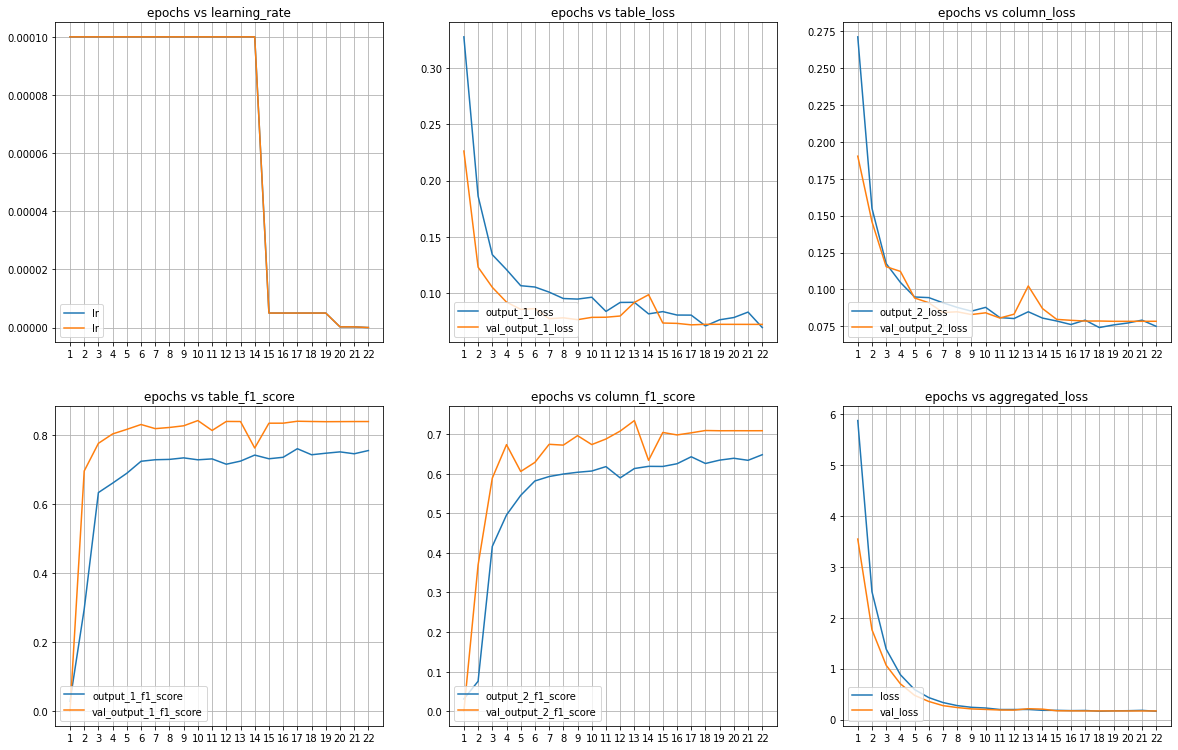

In [37]:
visualize_training(history)

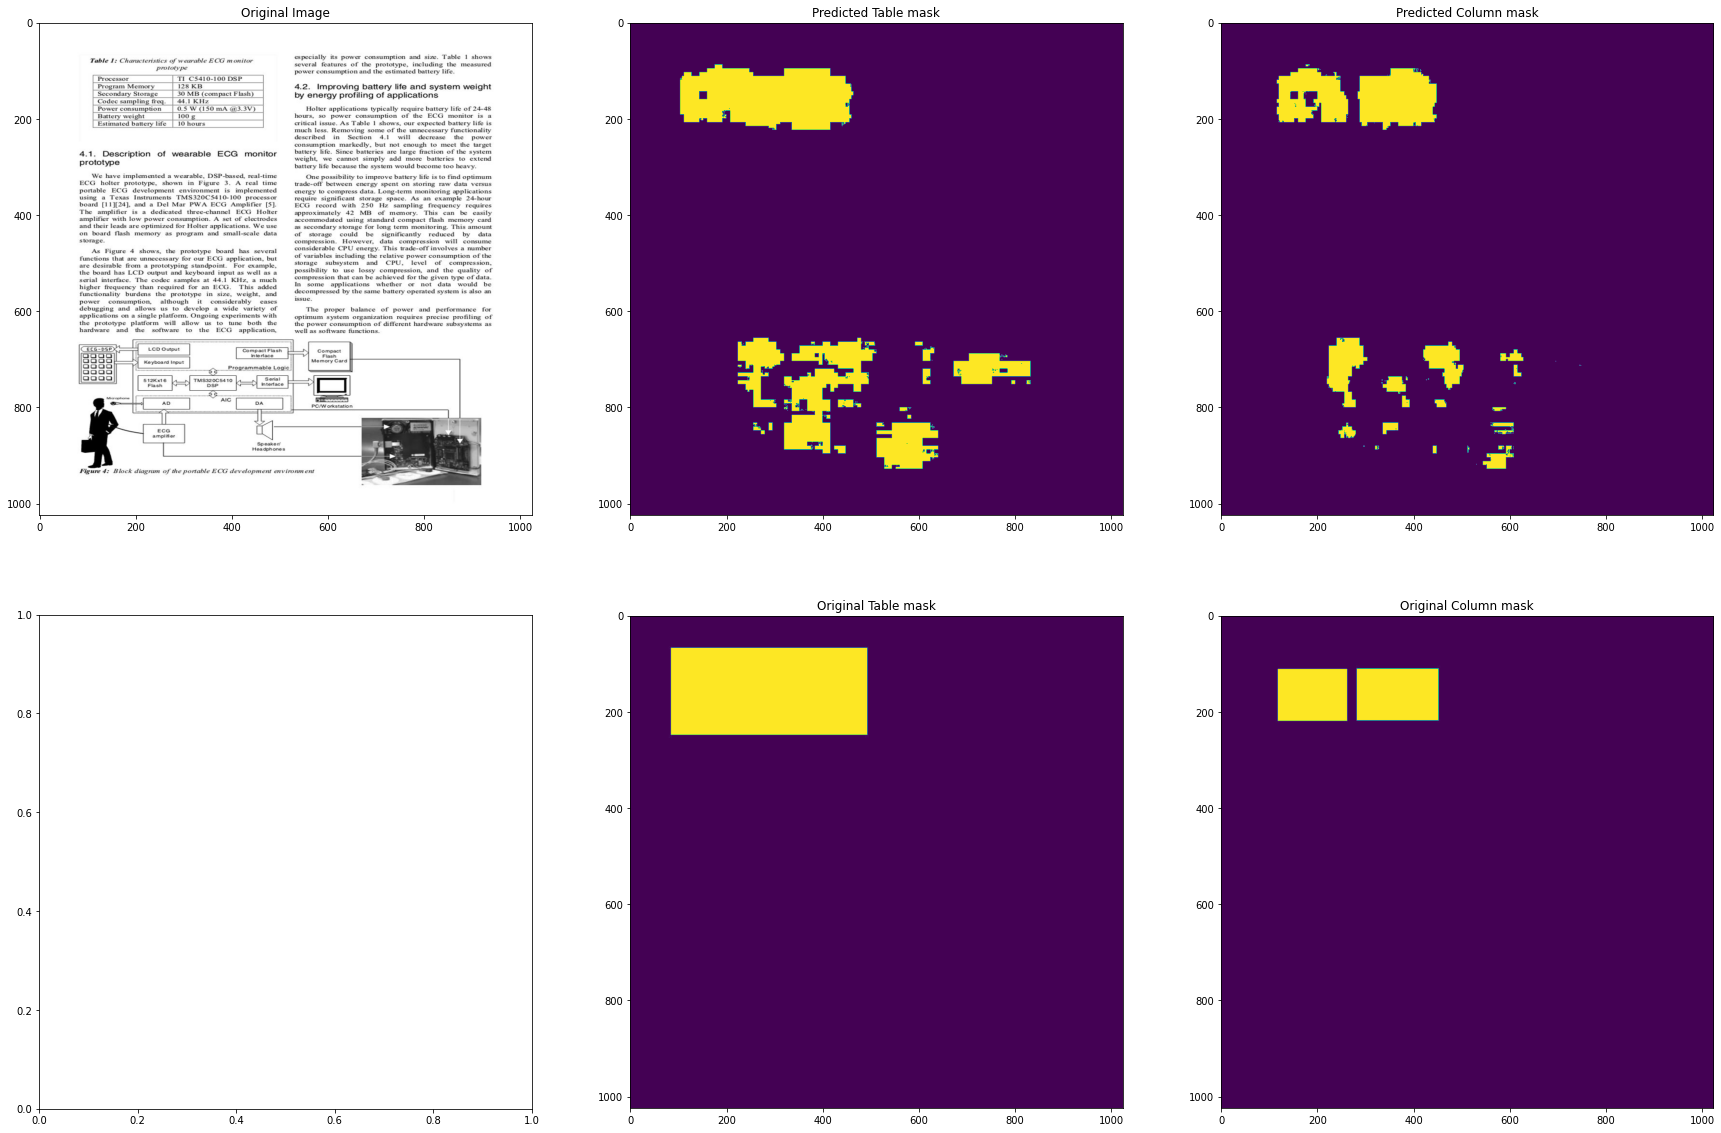

In [38]:
visualize_predictions(model_dense, 'marmot_preprocessed/image/10.1.1.33.5766_4.jpeg')

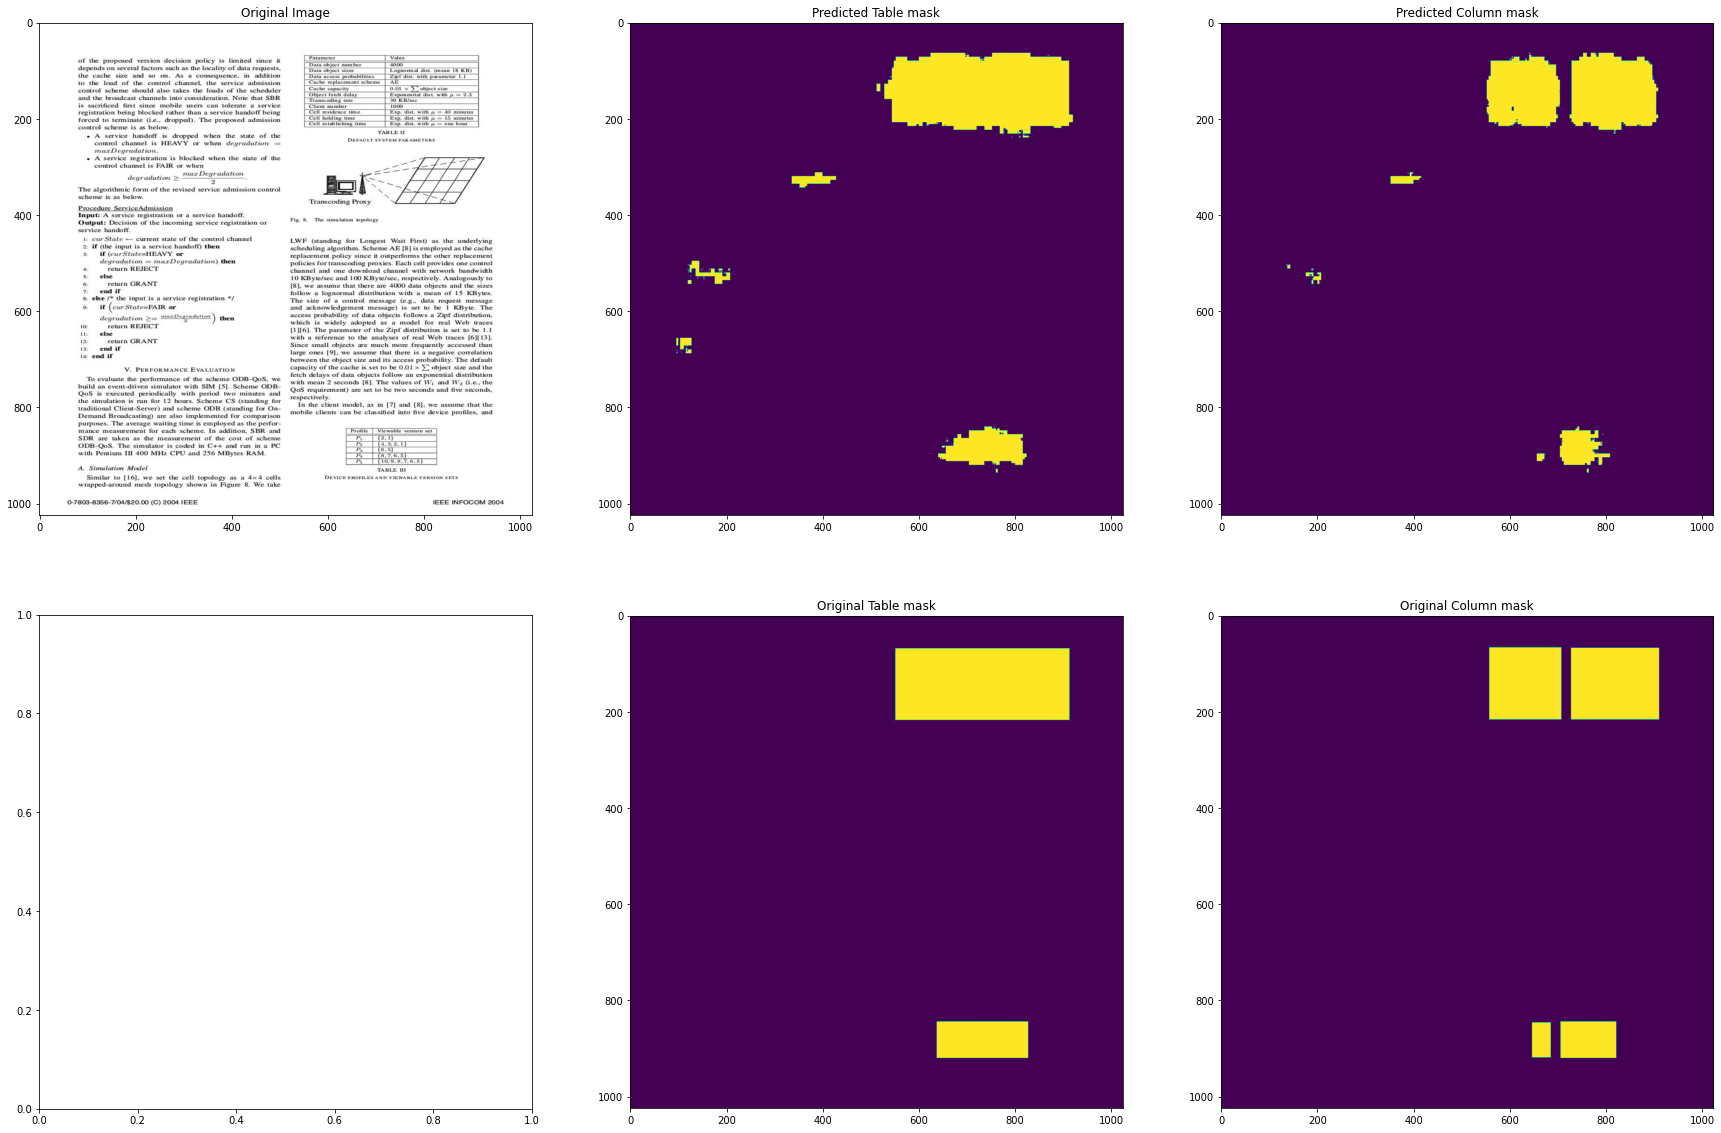

In [39]:
visualize_predictions(model_dense, 'marmot_preprocessed/image/10.1.1.1.2018_8.jpeg')

# Visualize predictions on sample data

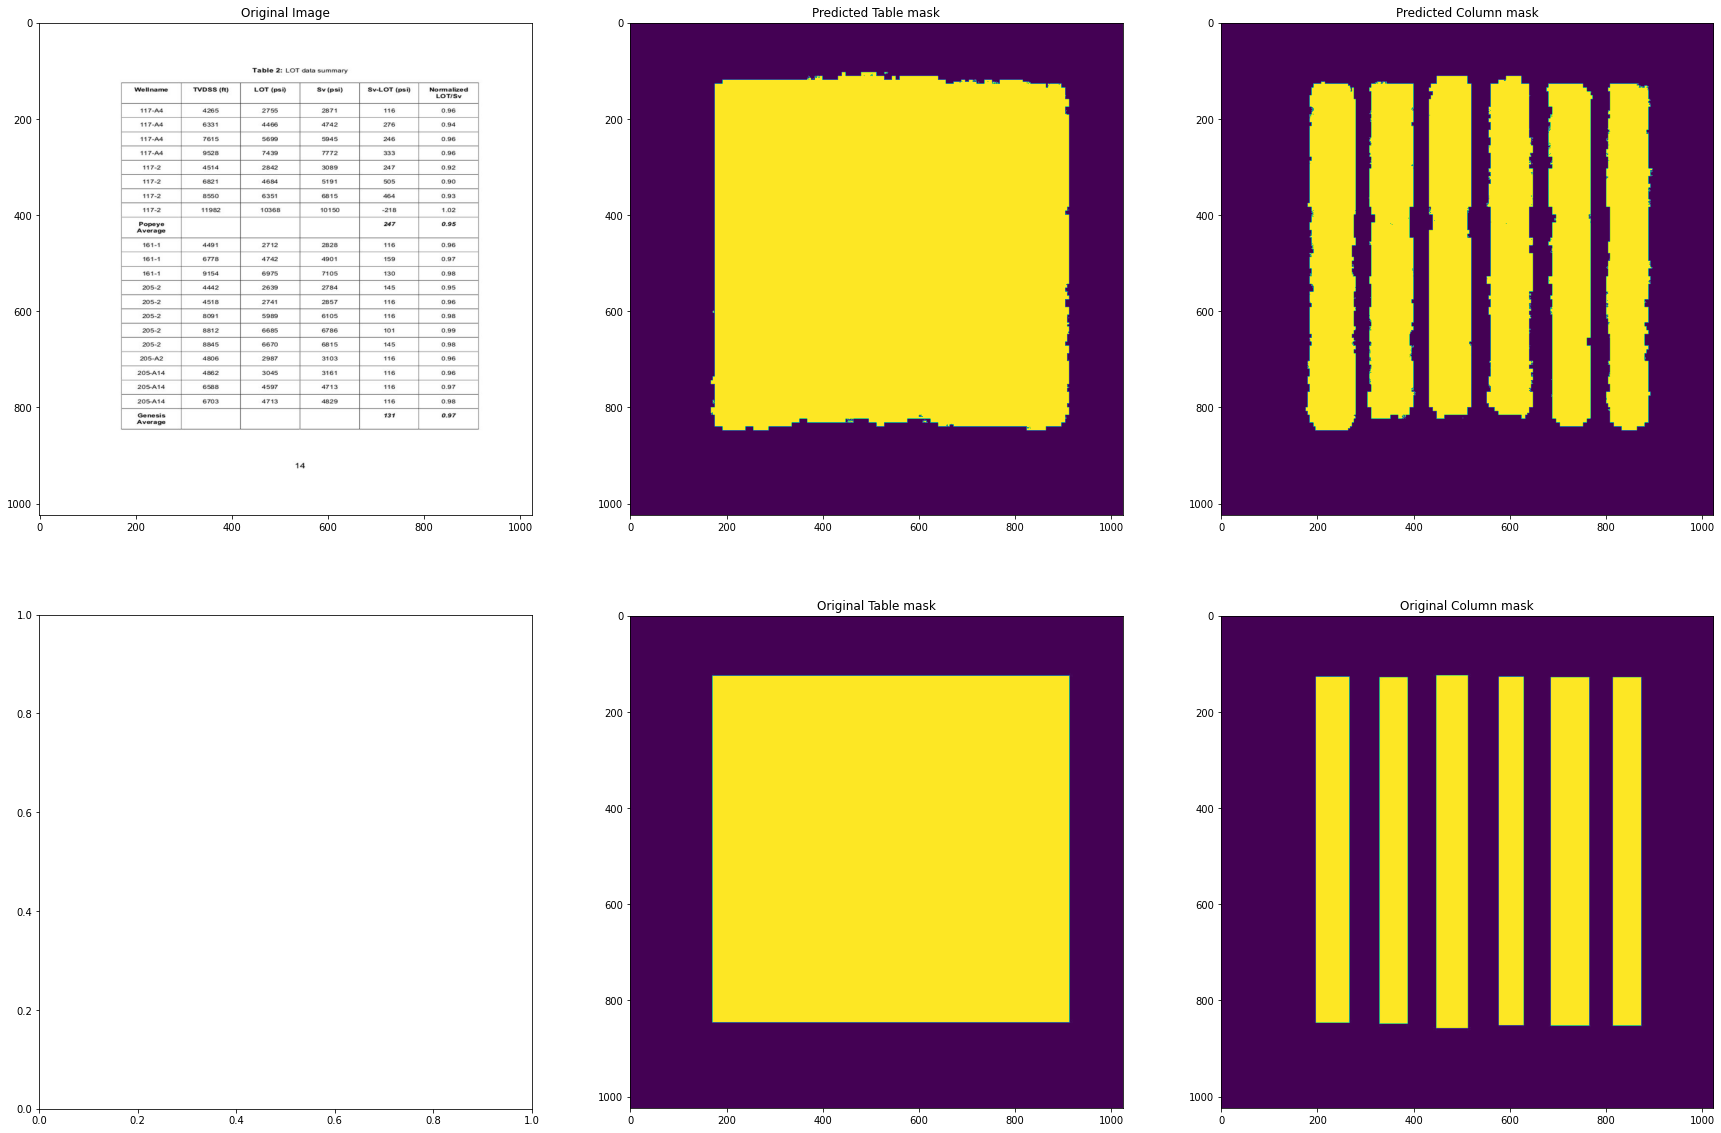

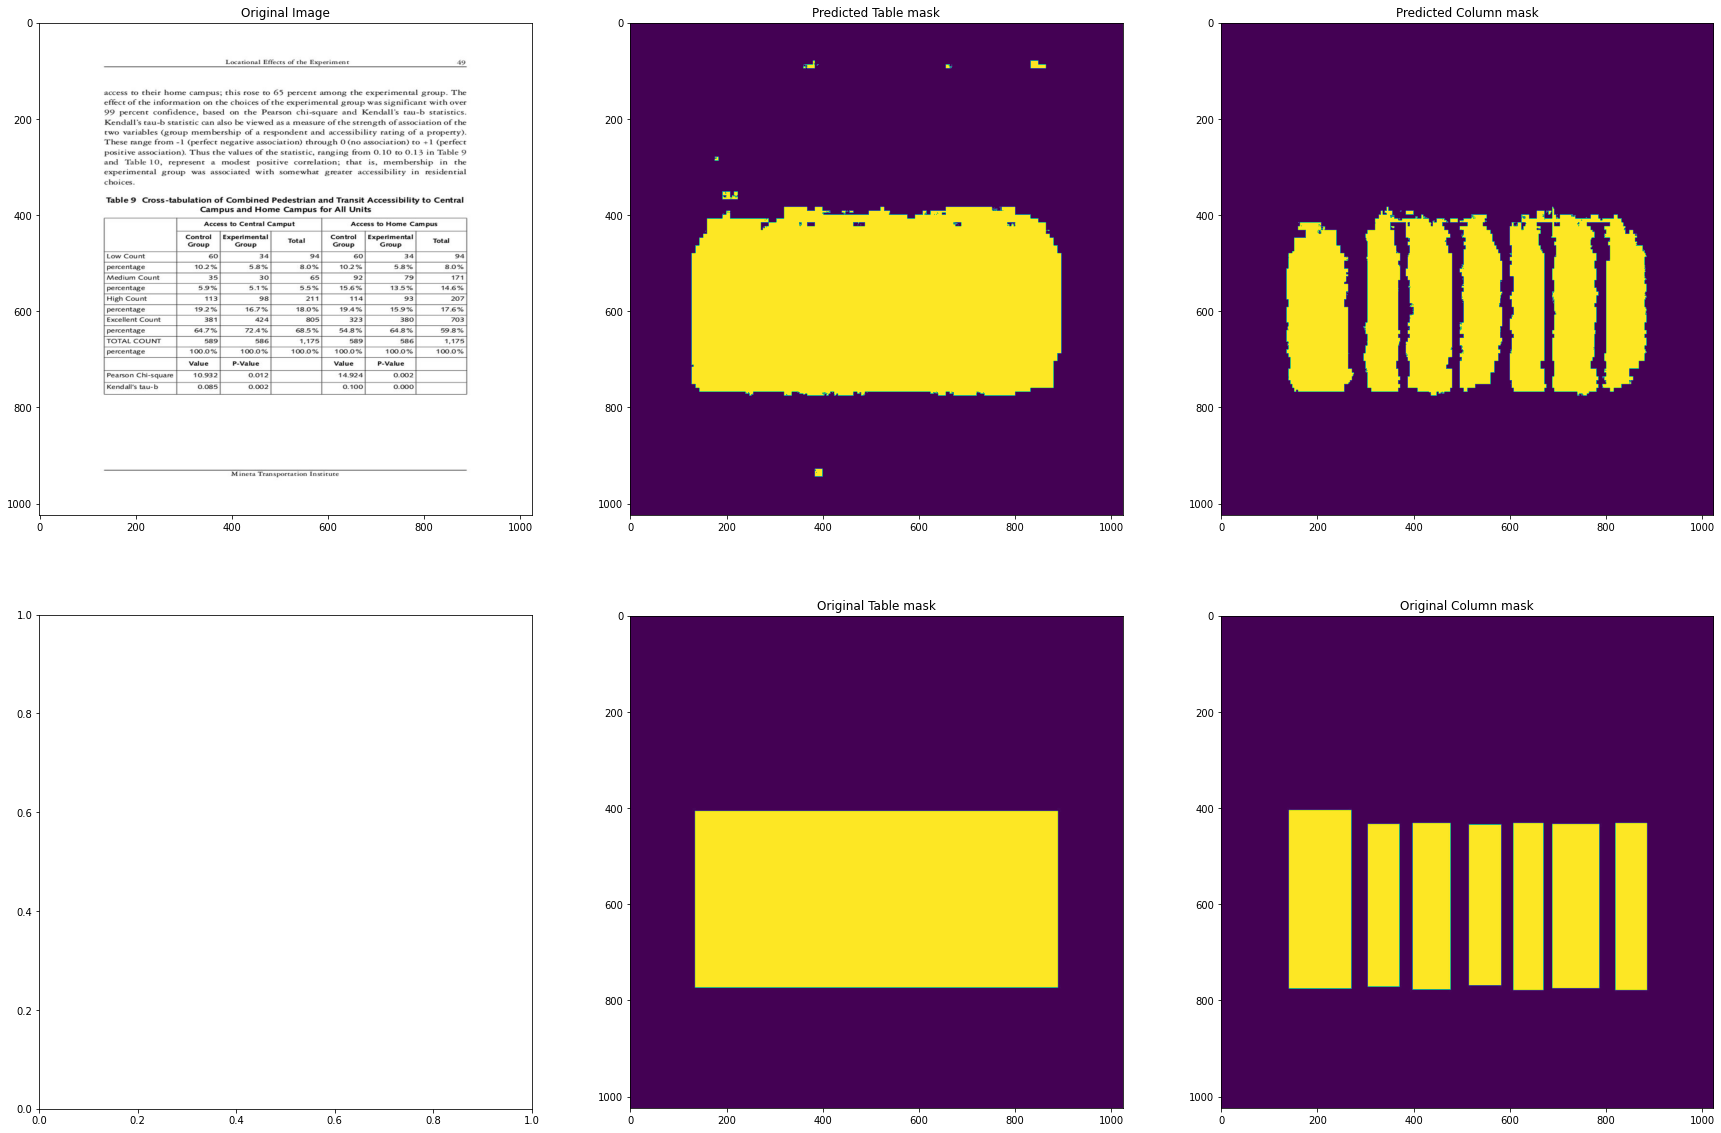

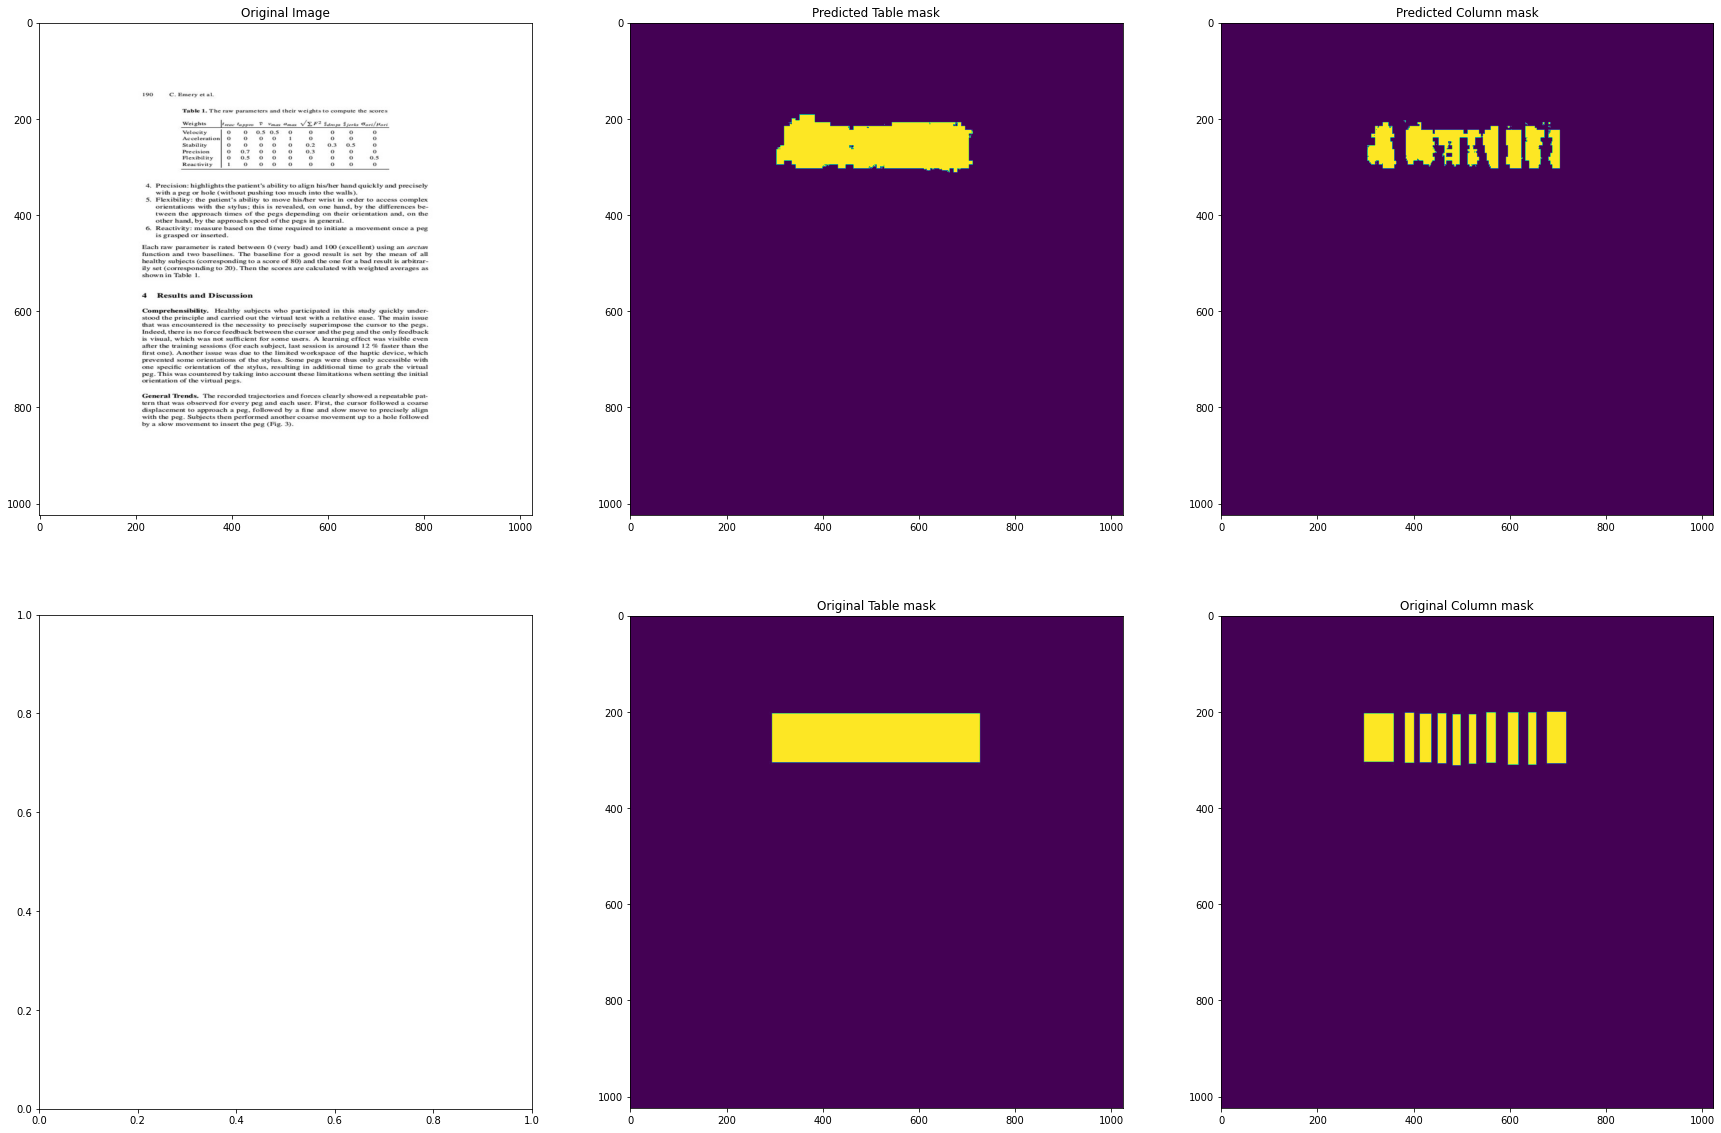

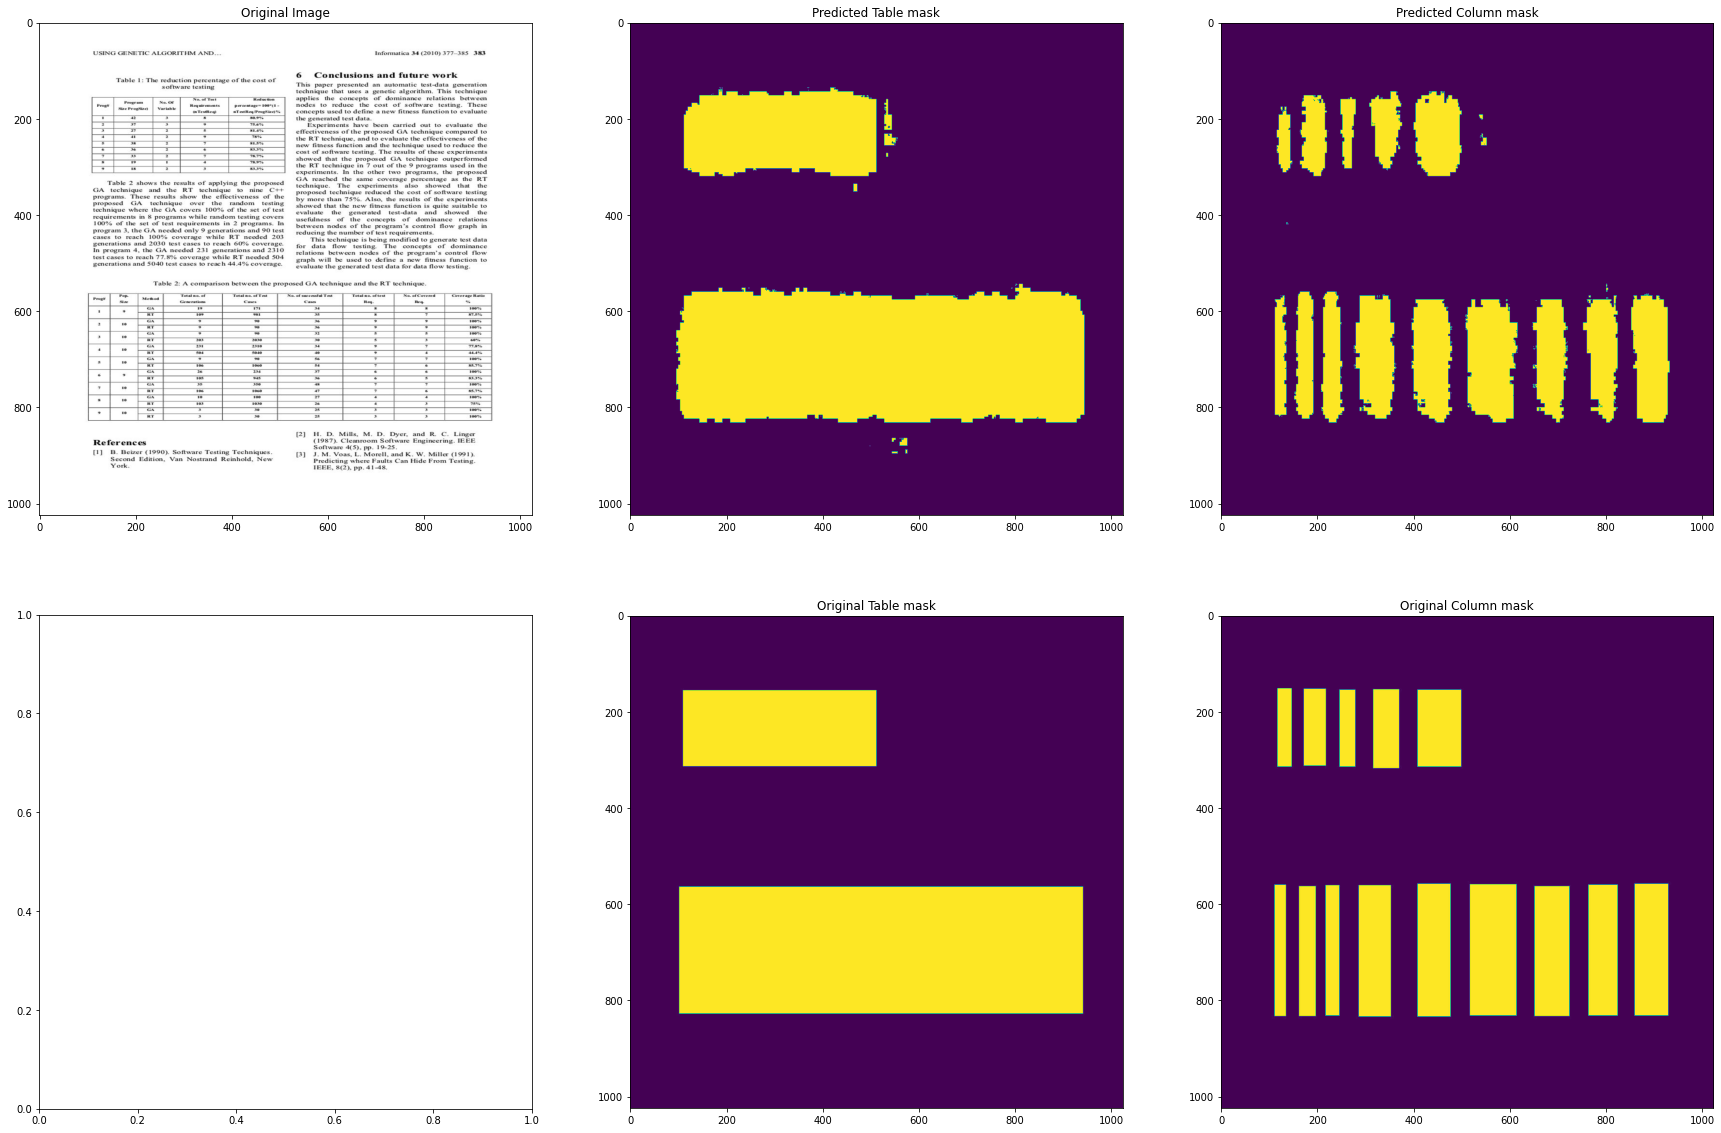

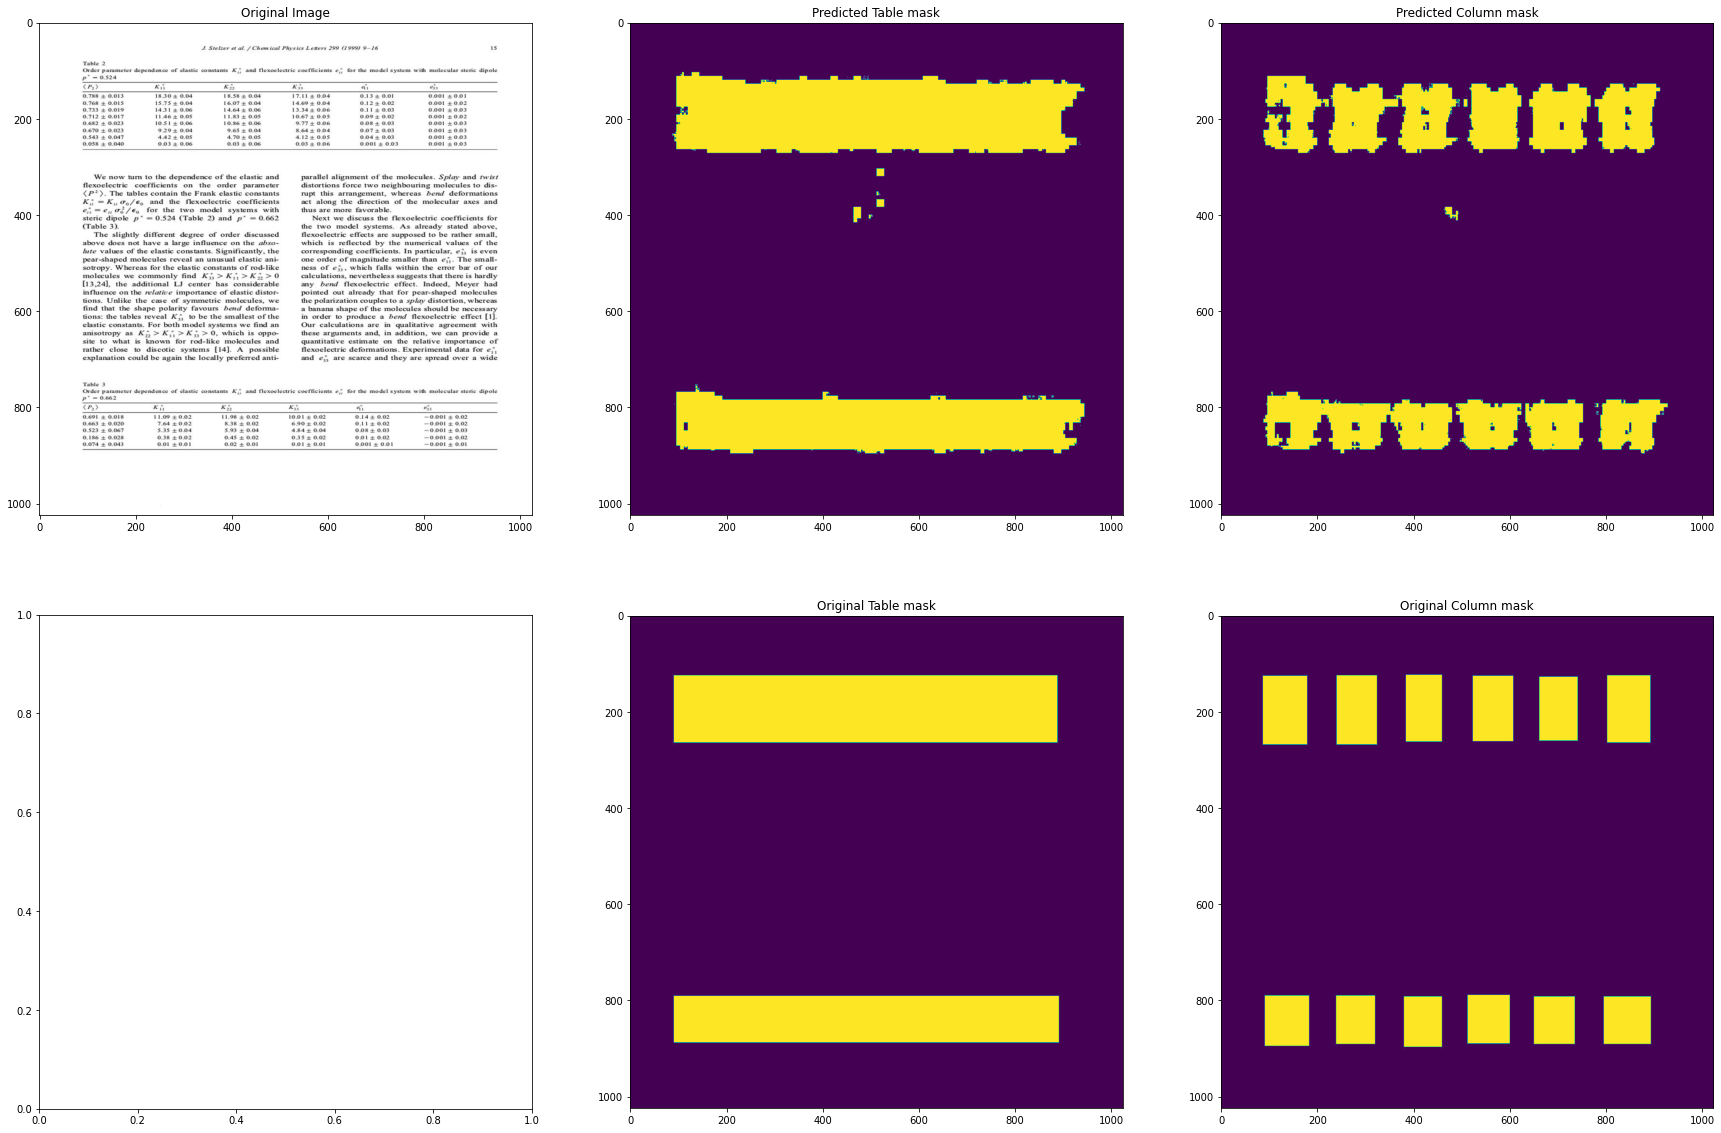

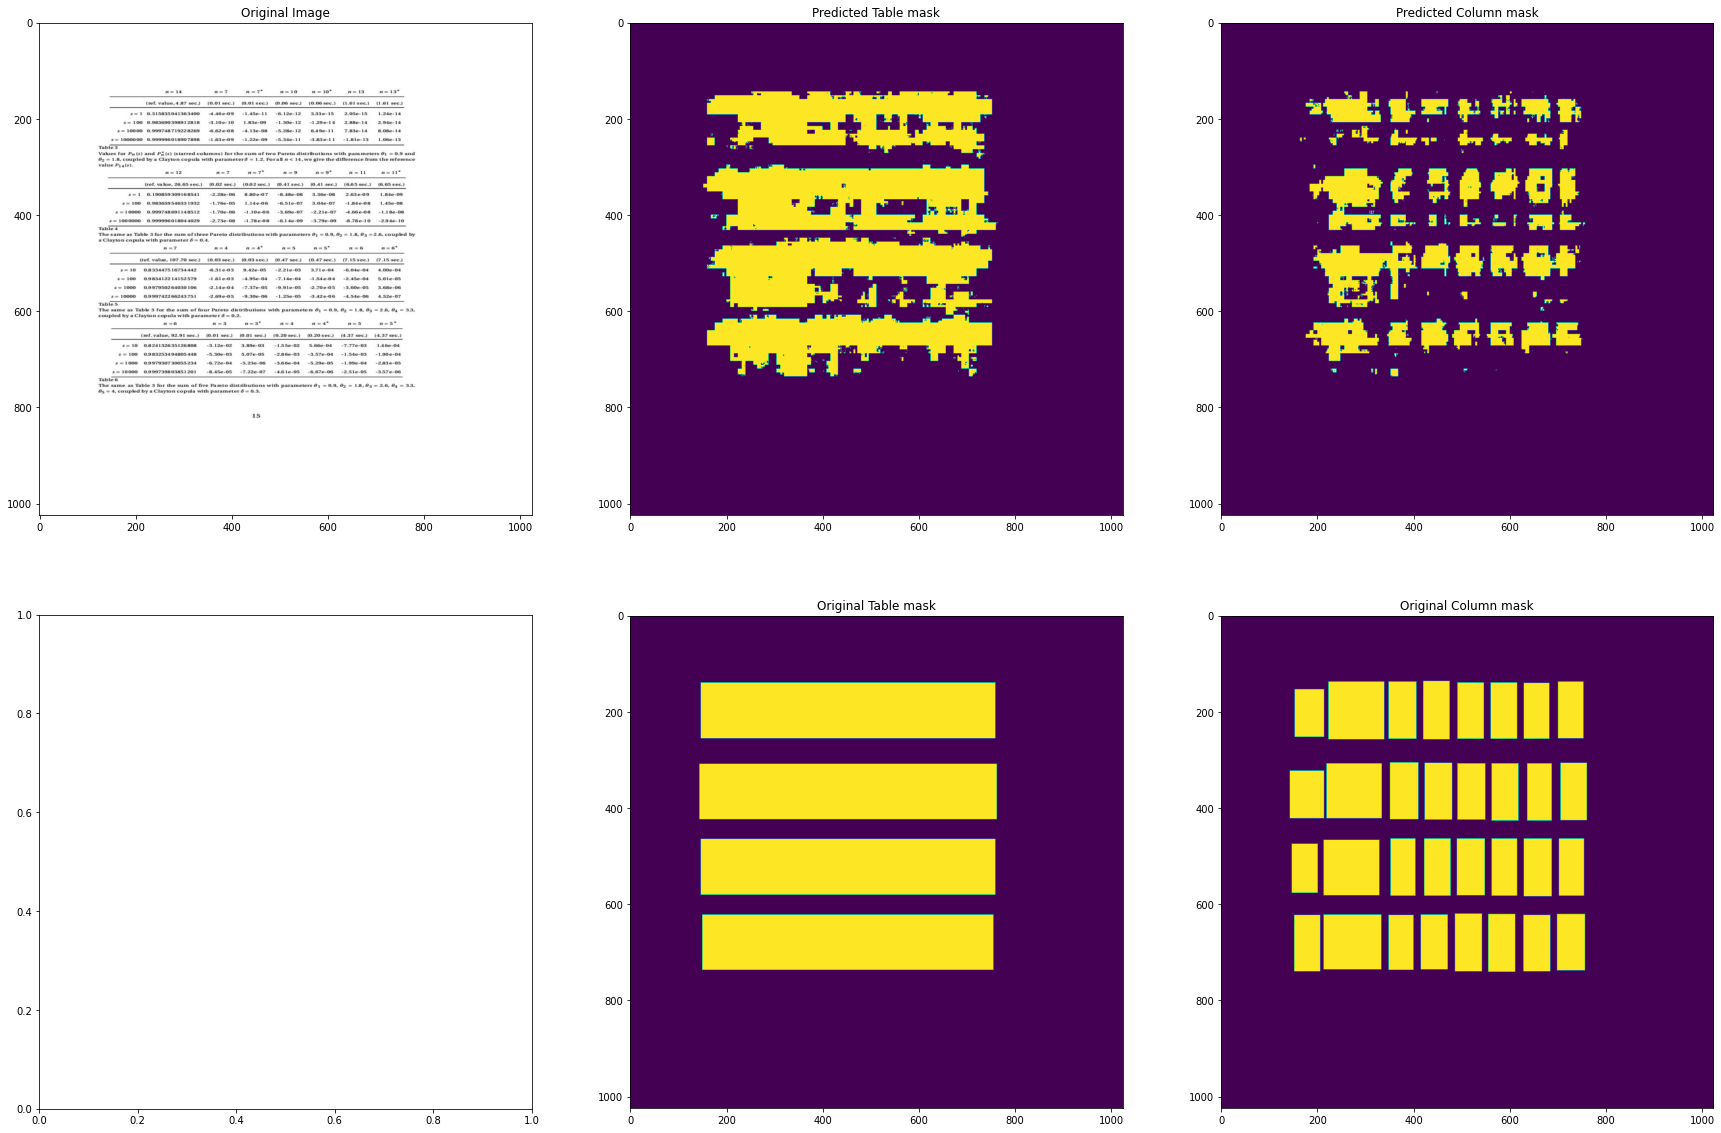

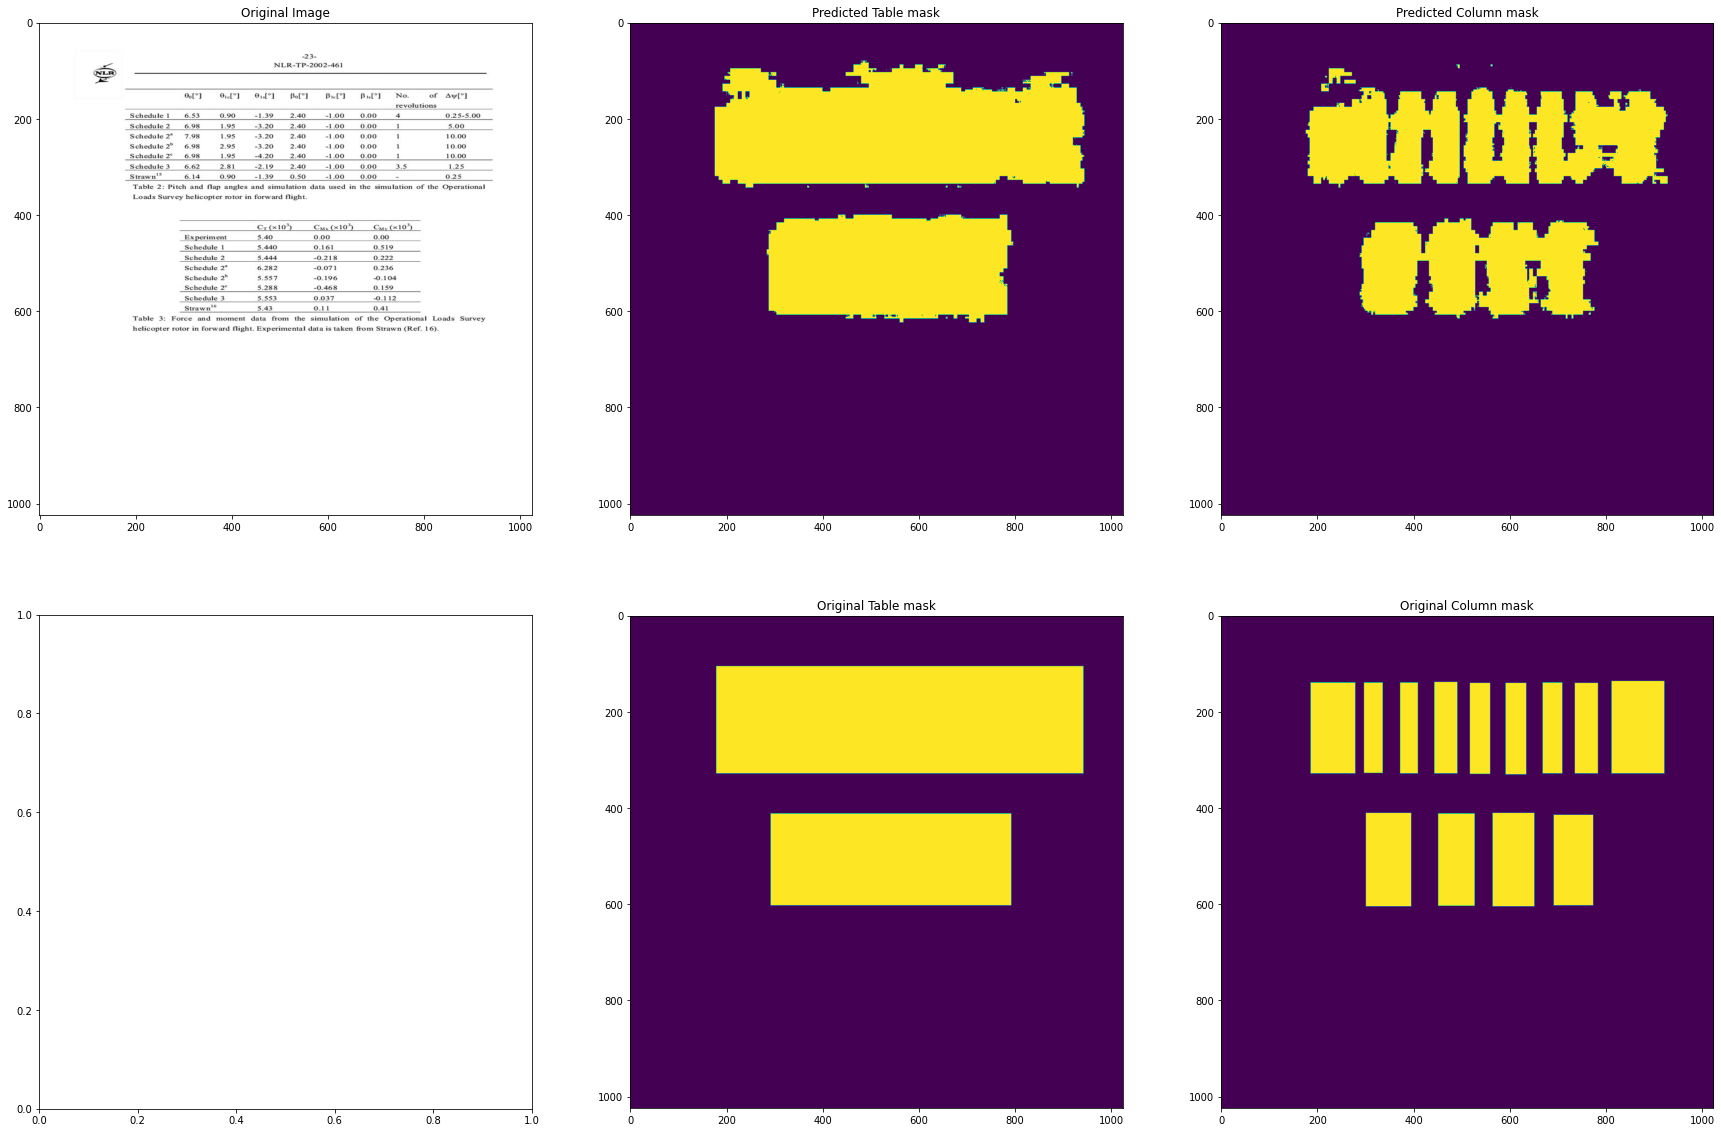

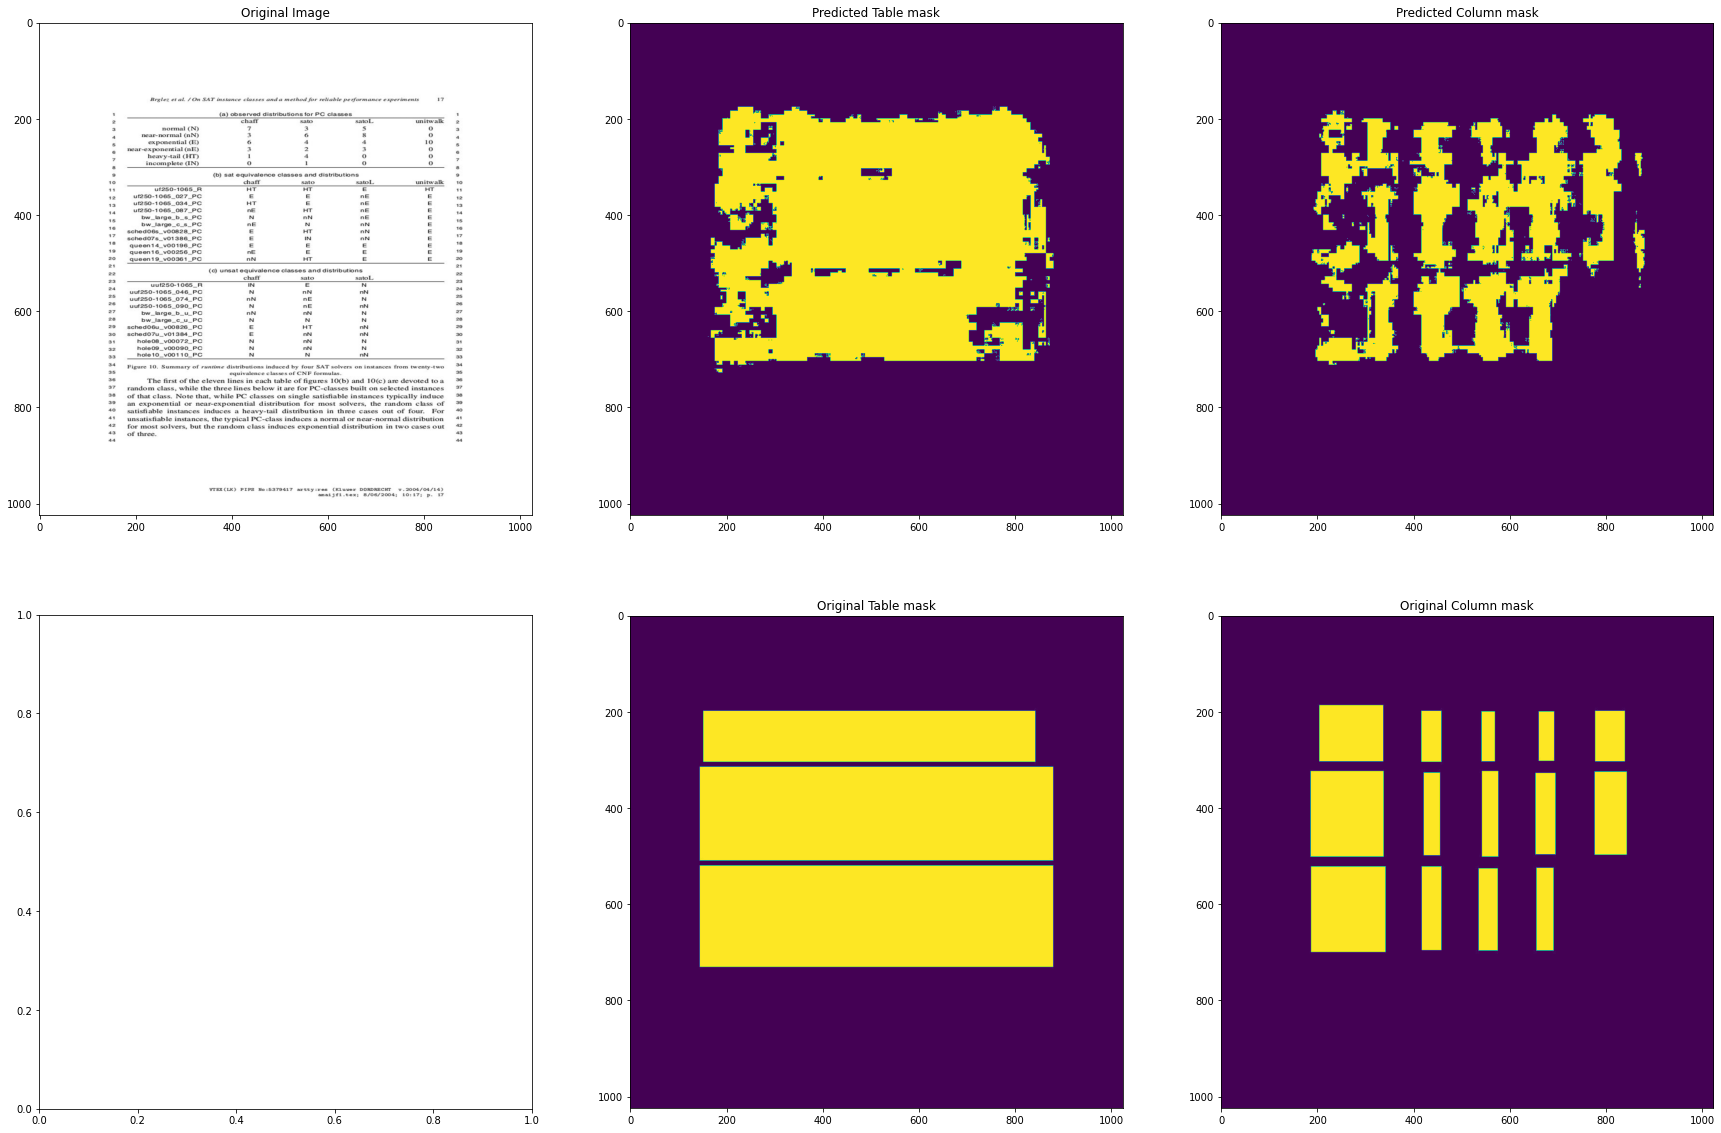

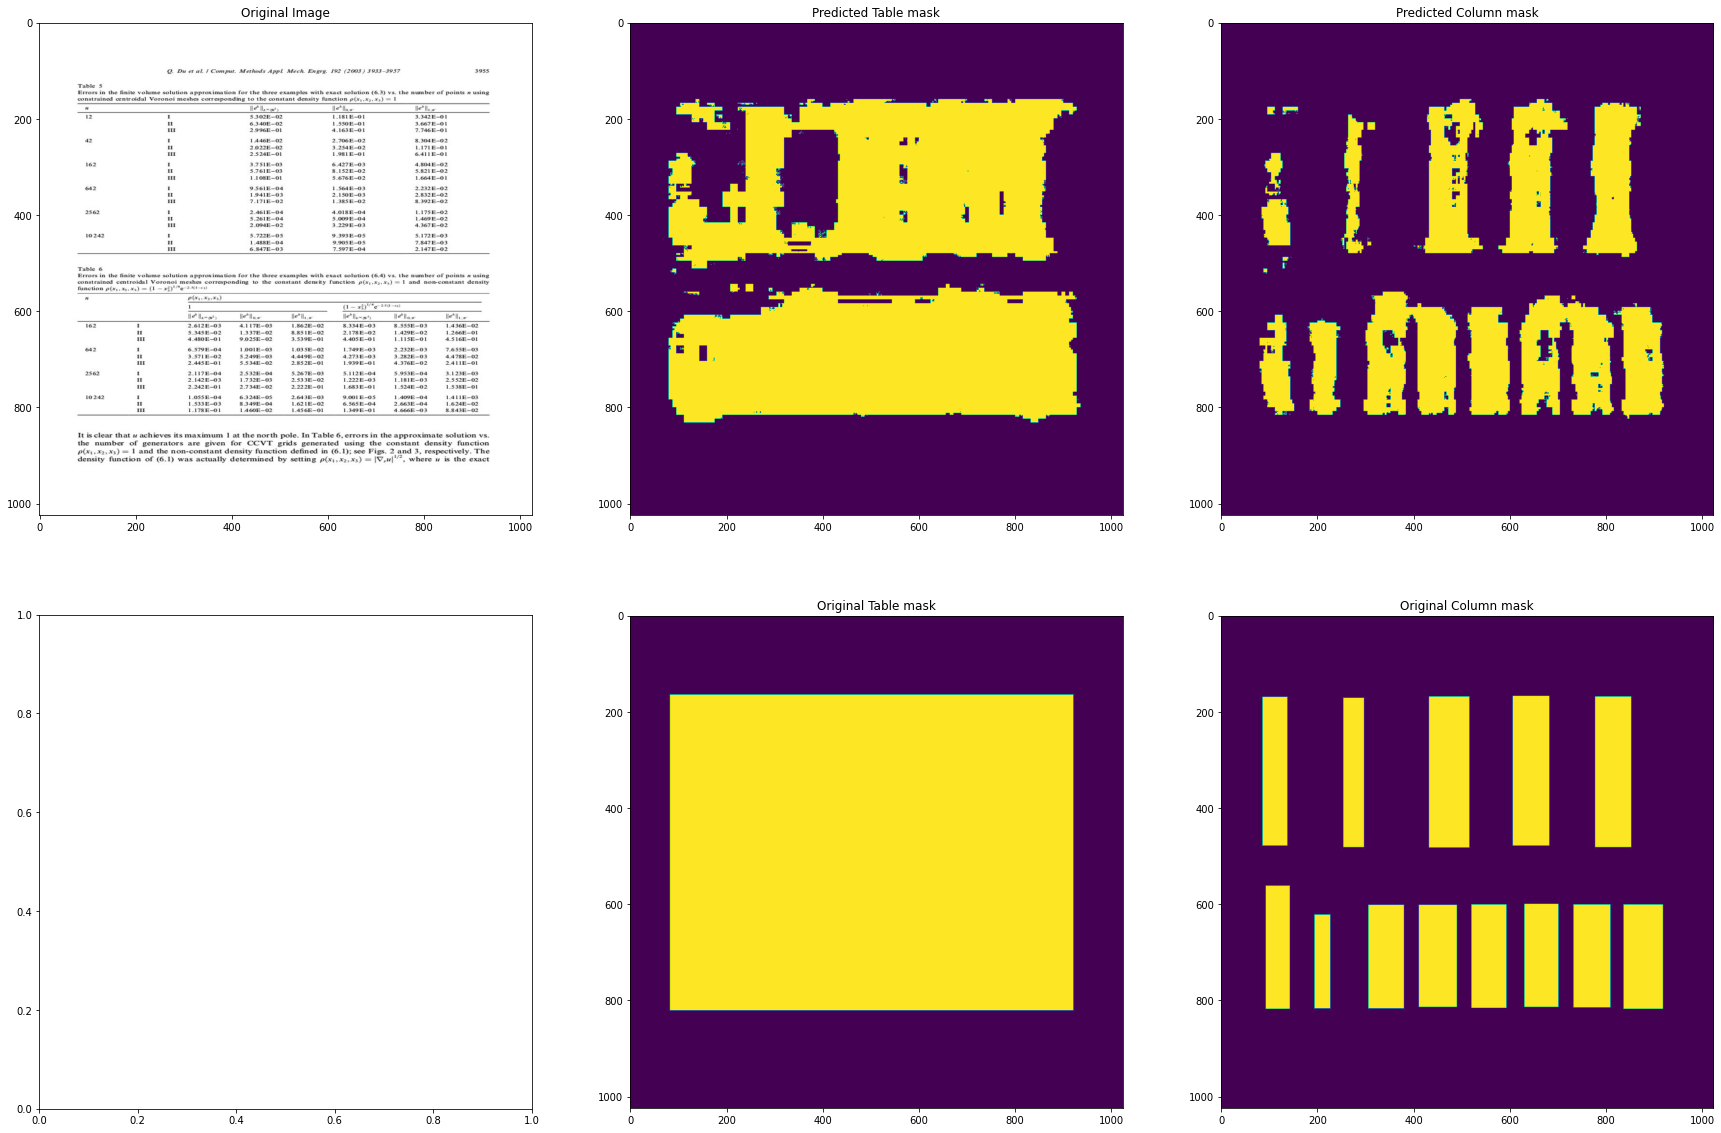

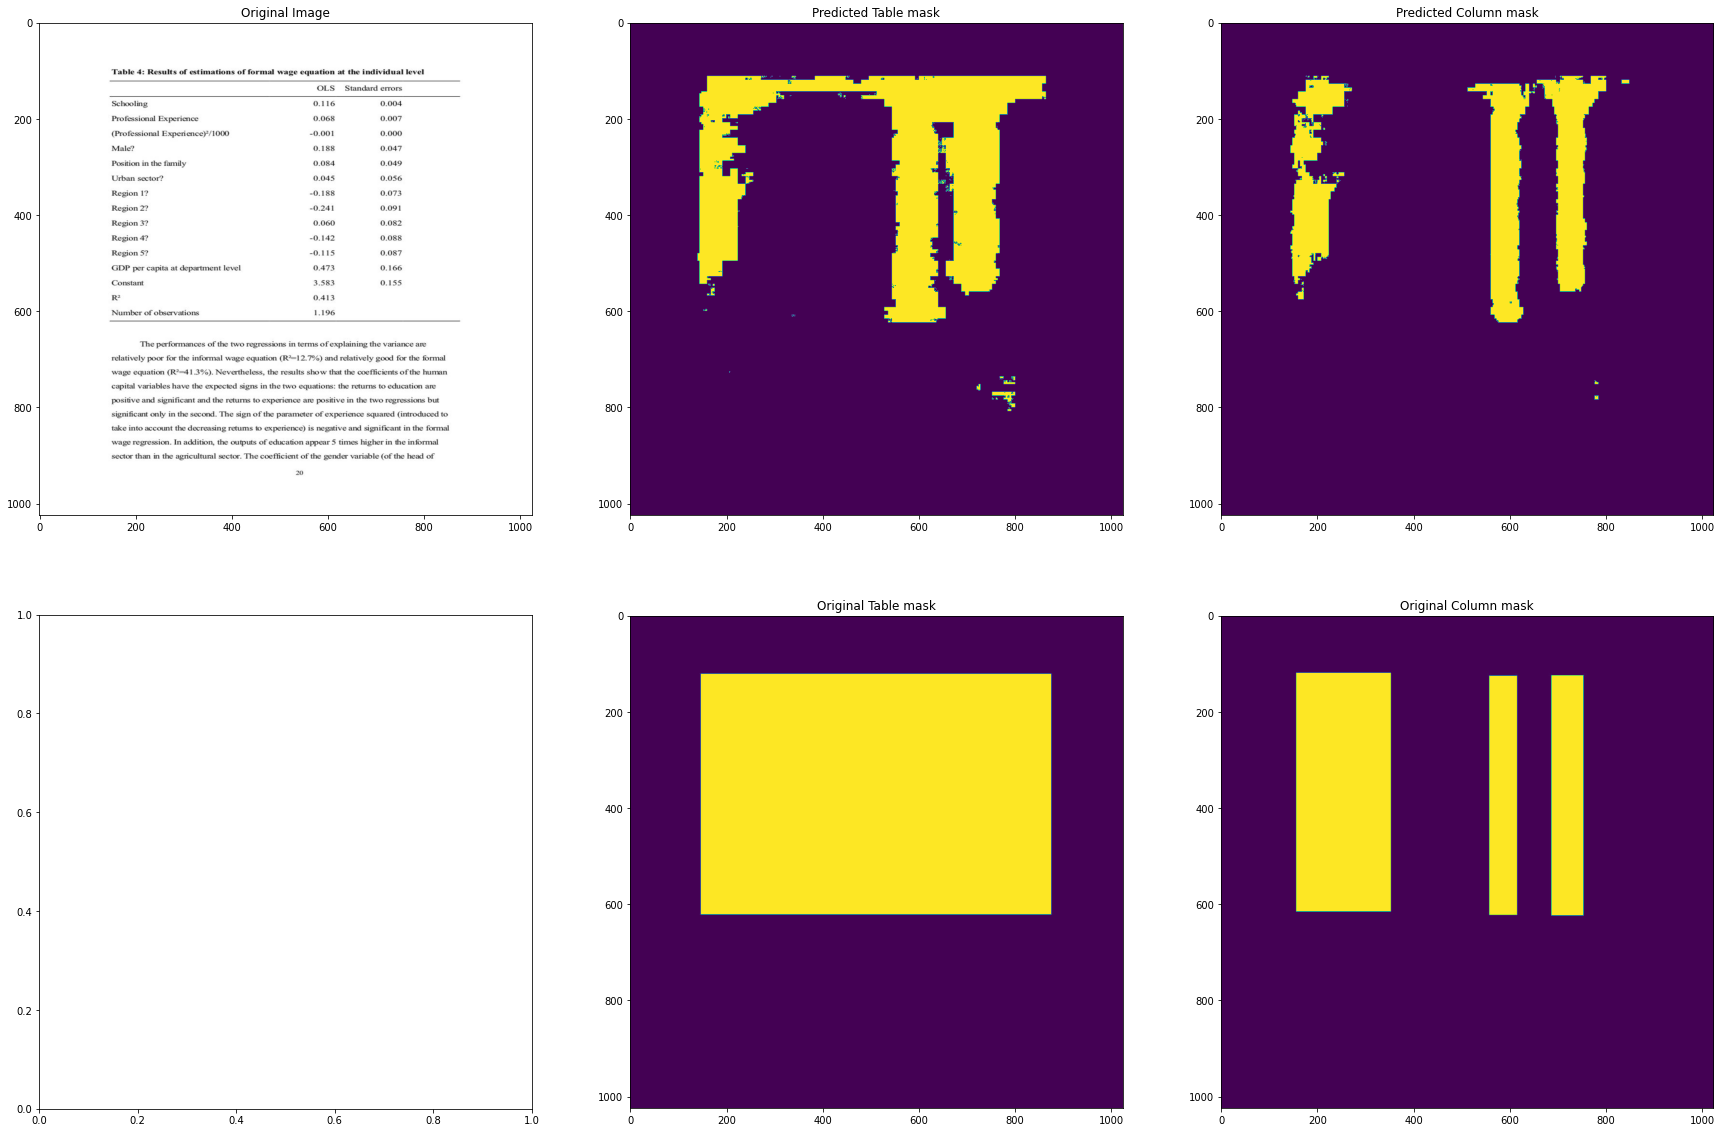

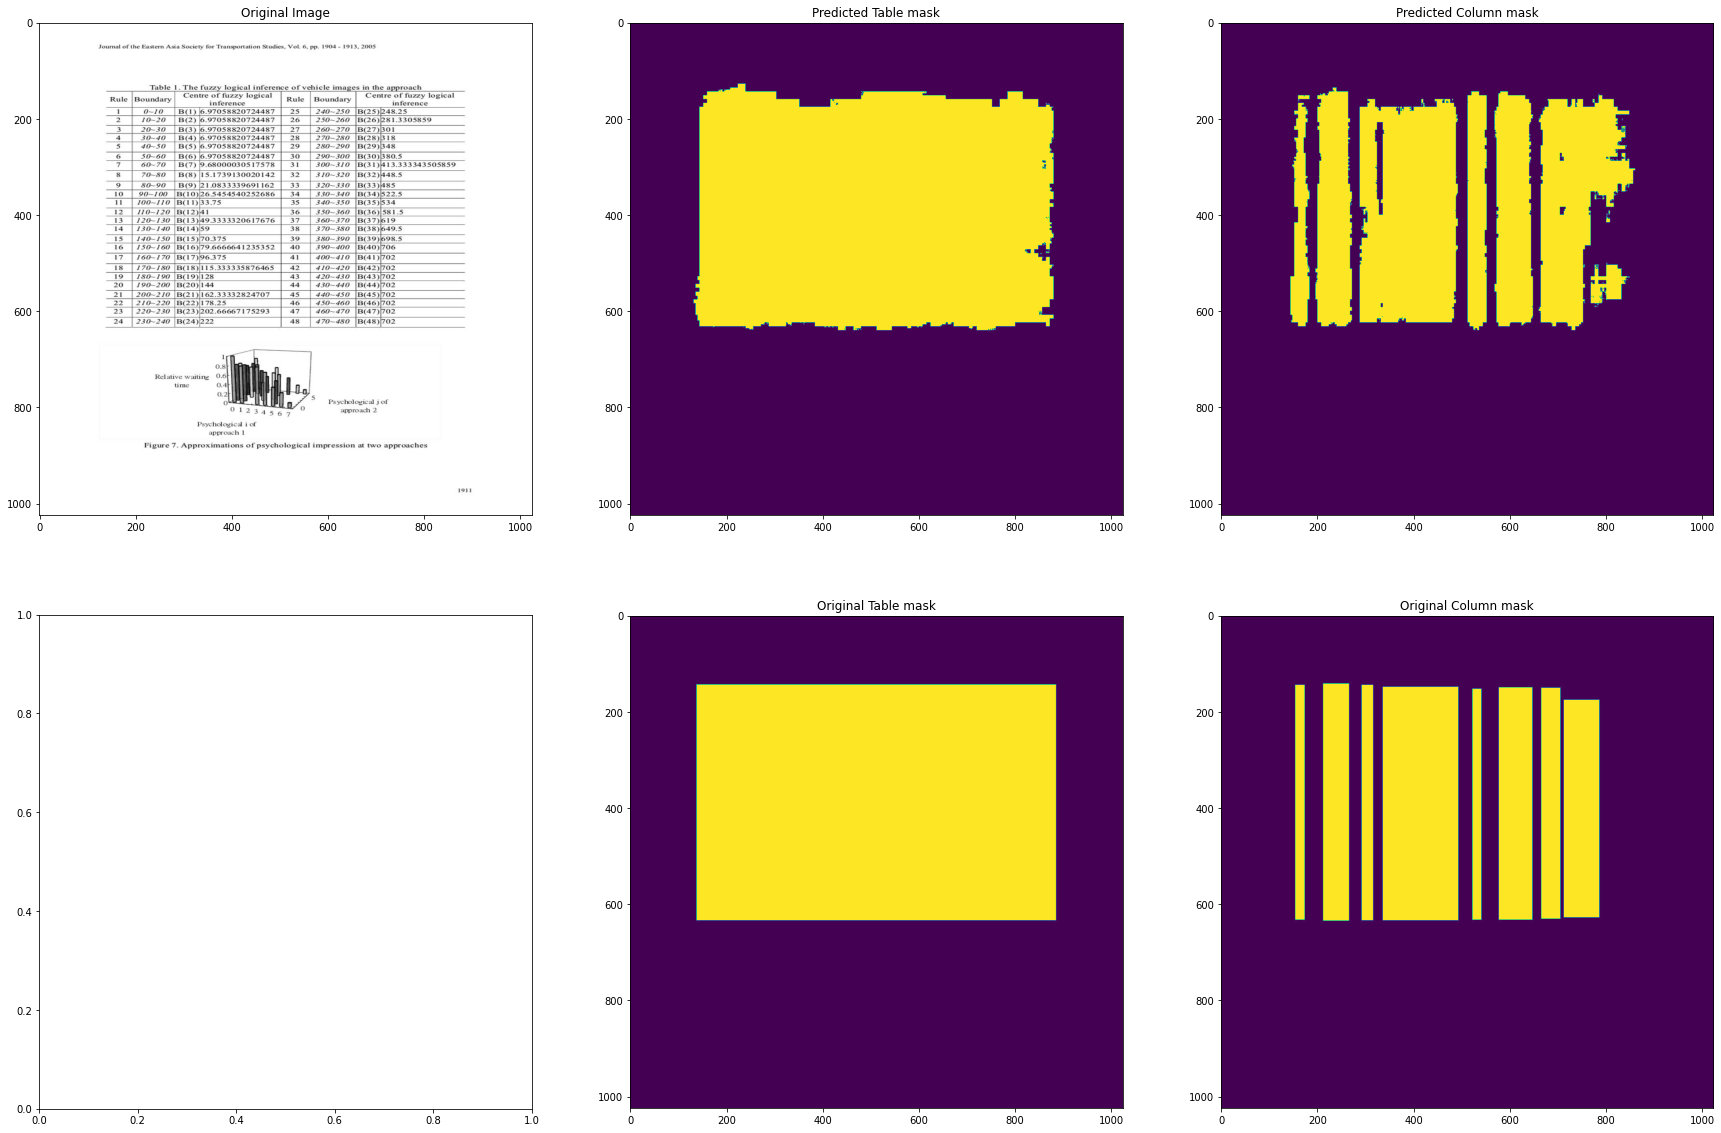

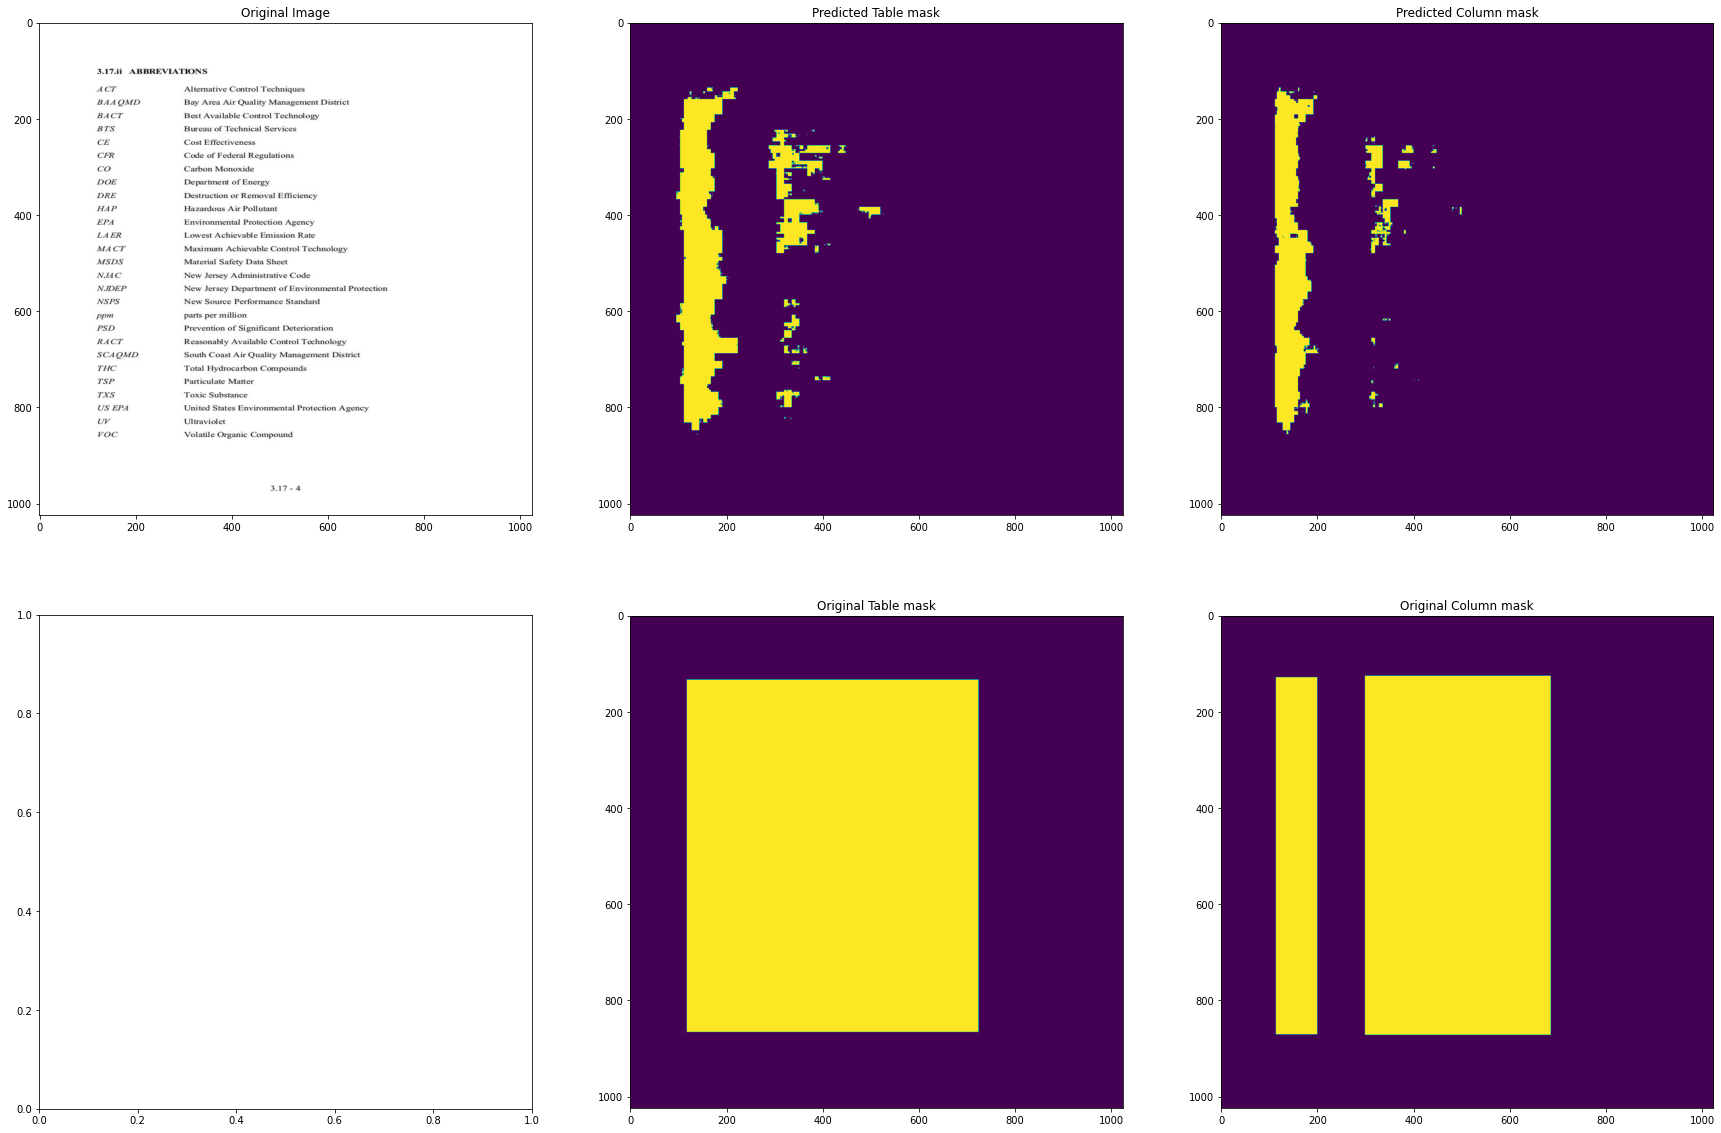

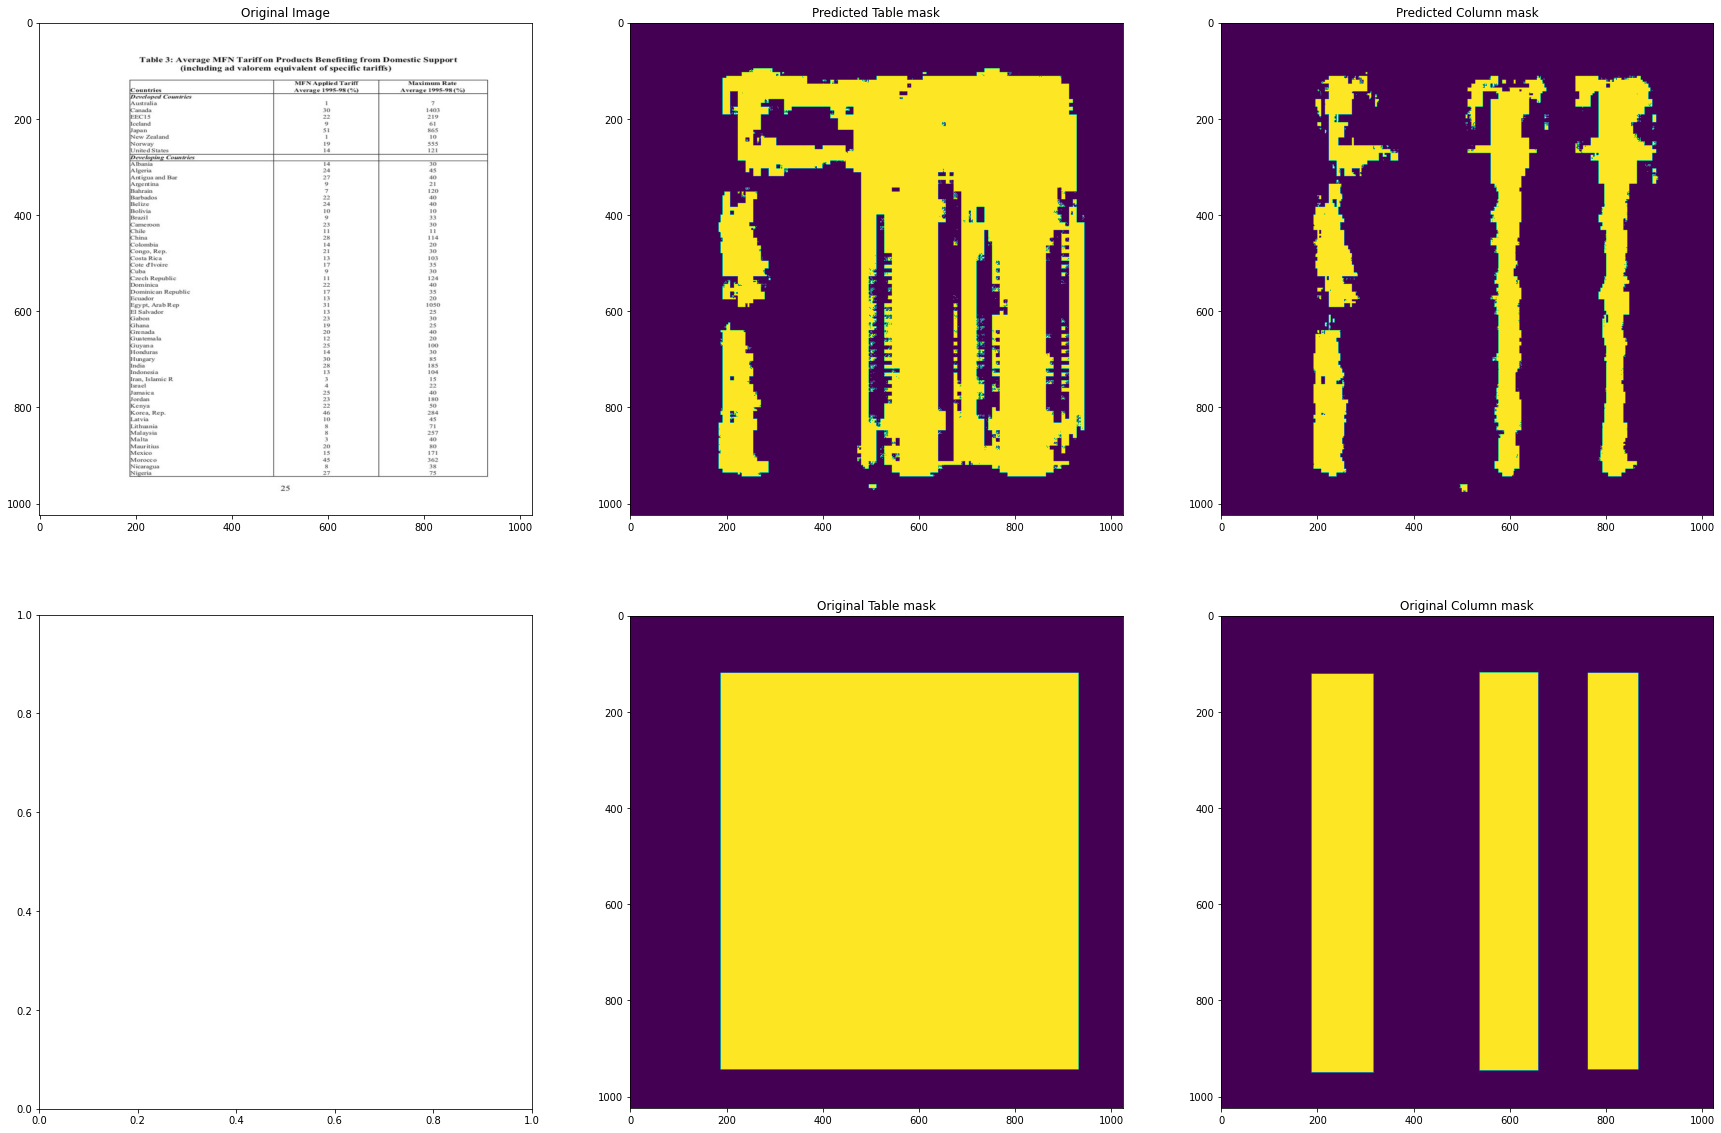

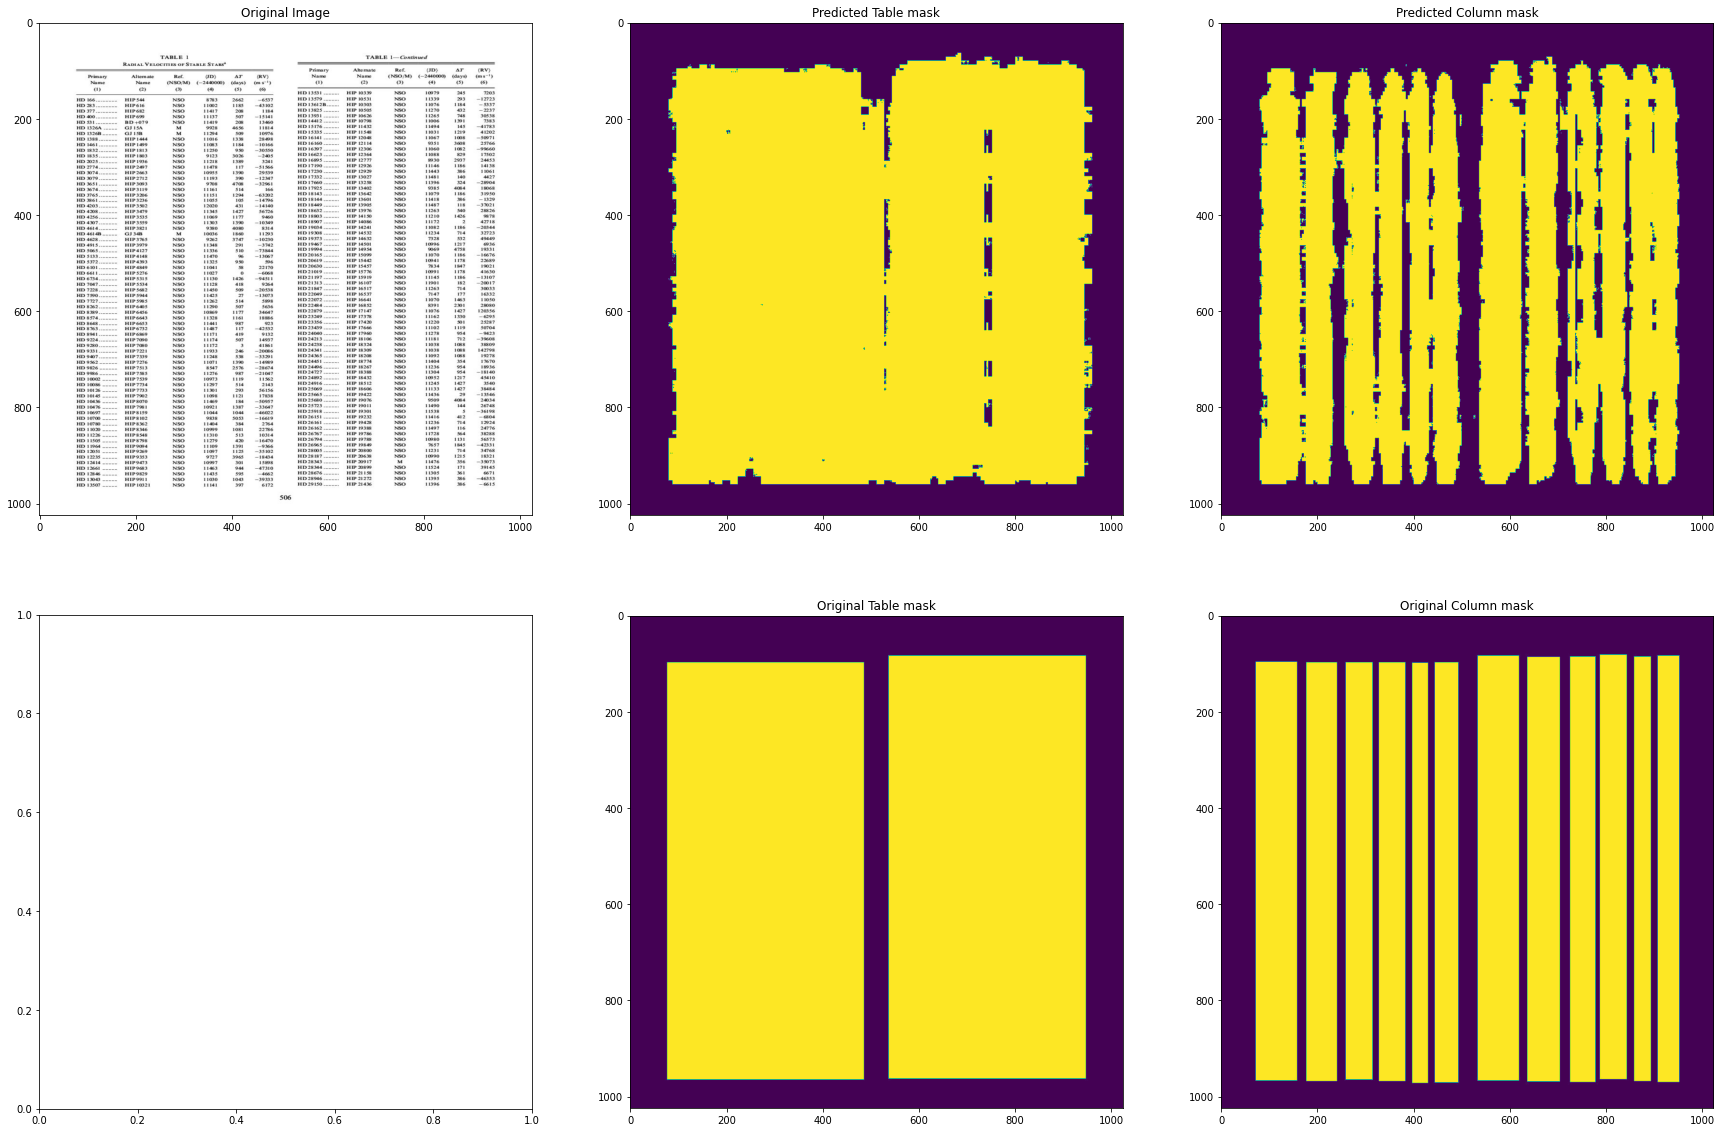

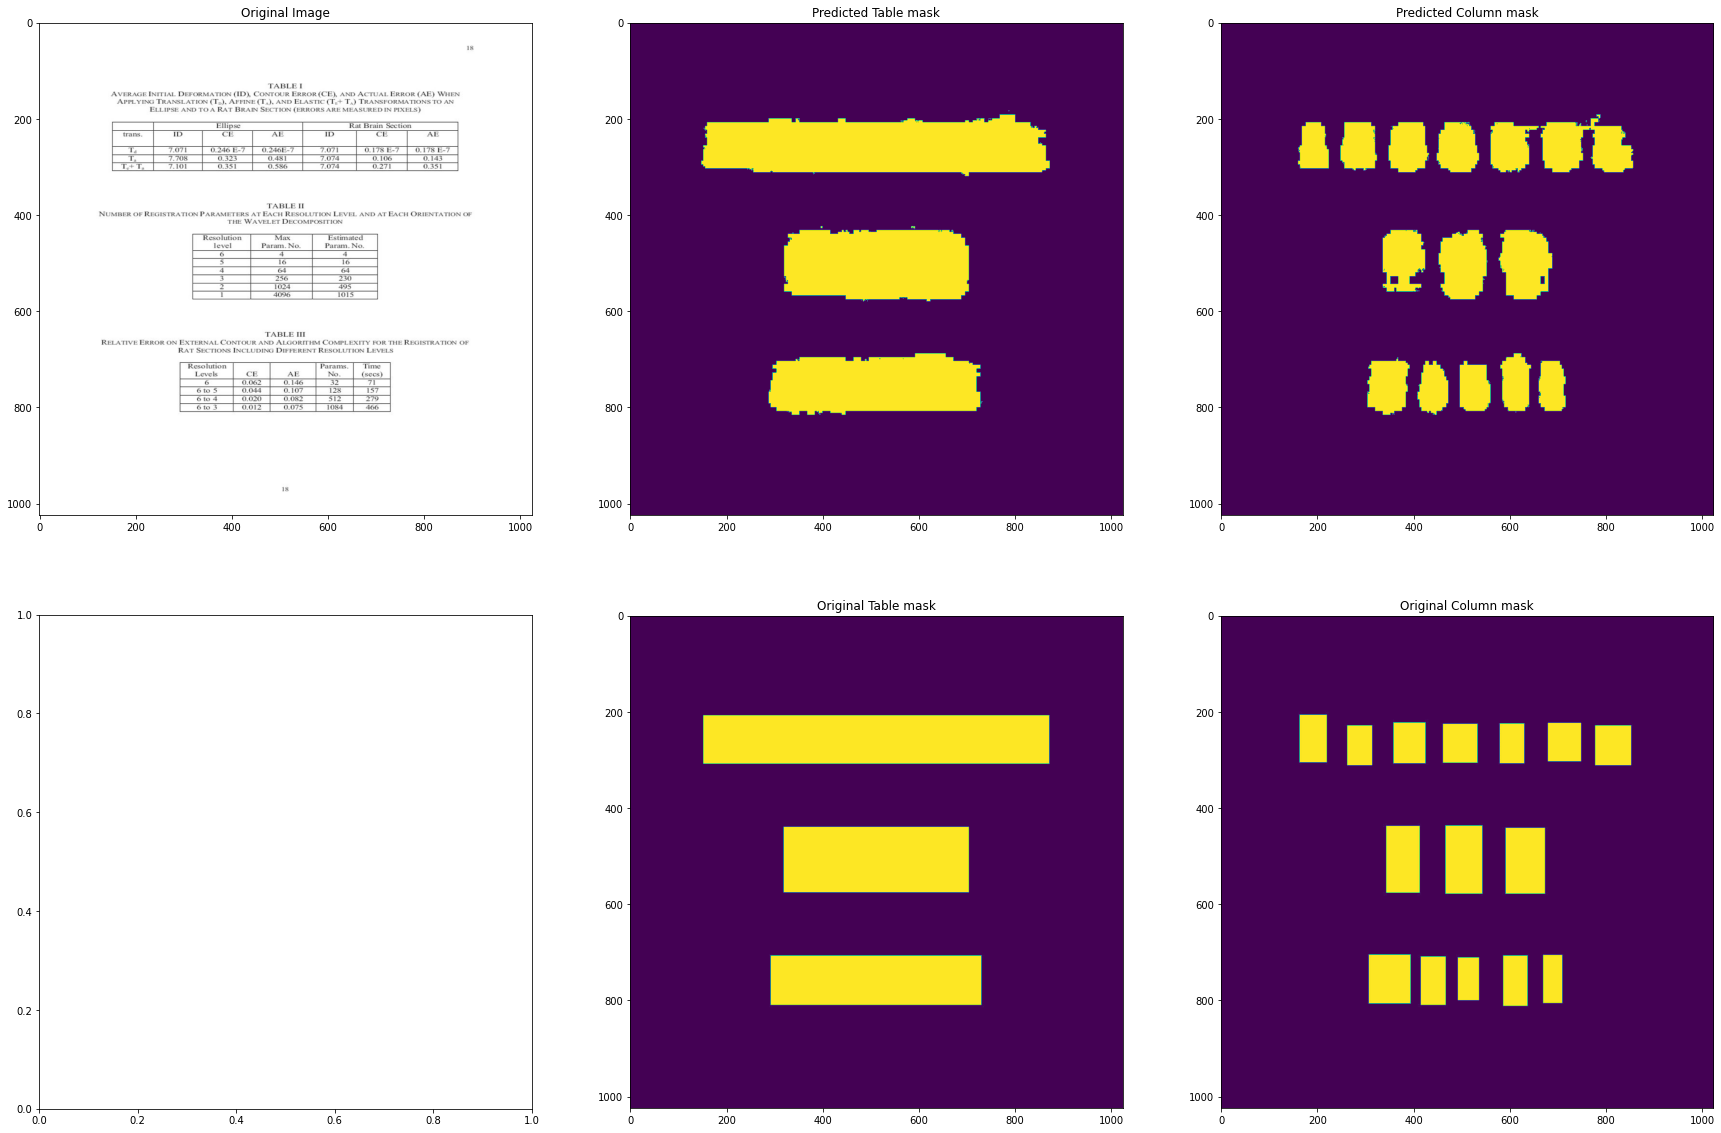

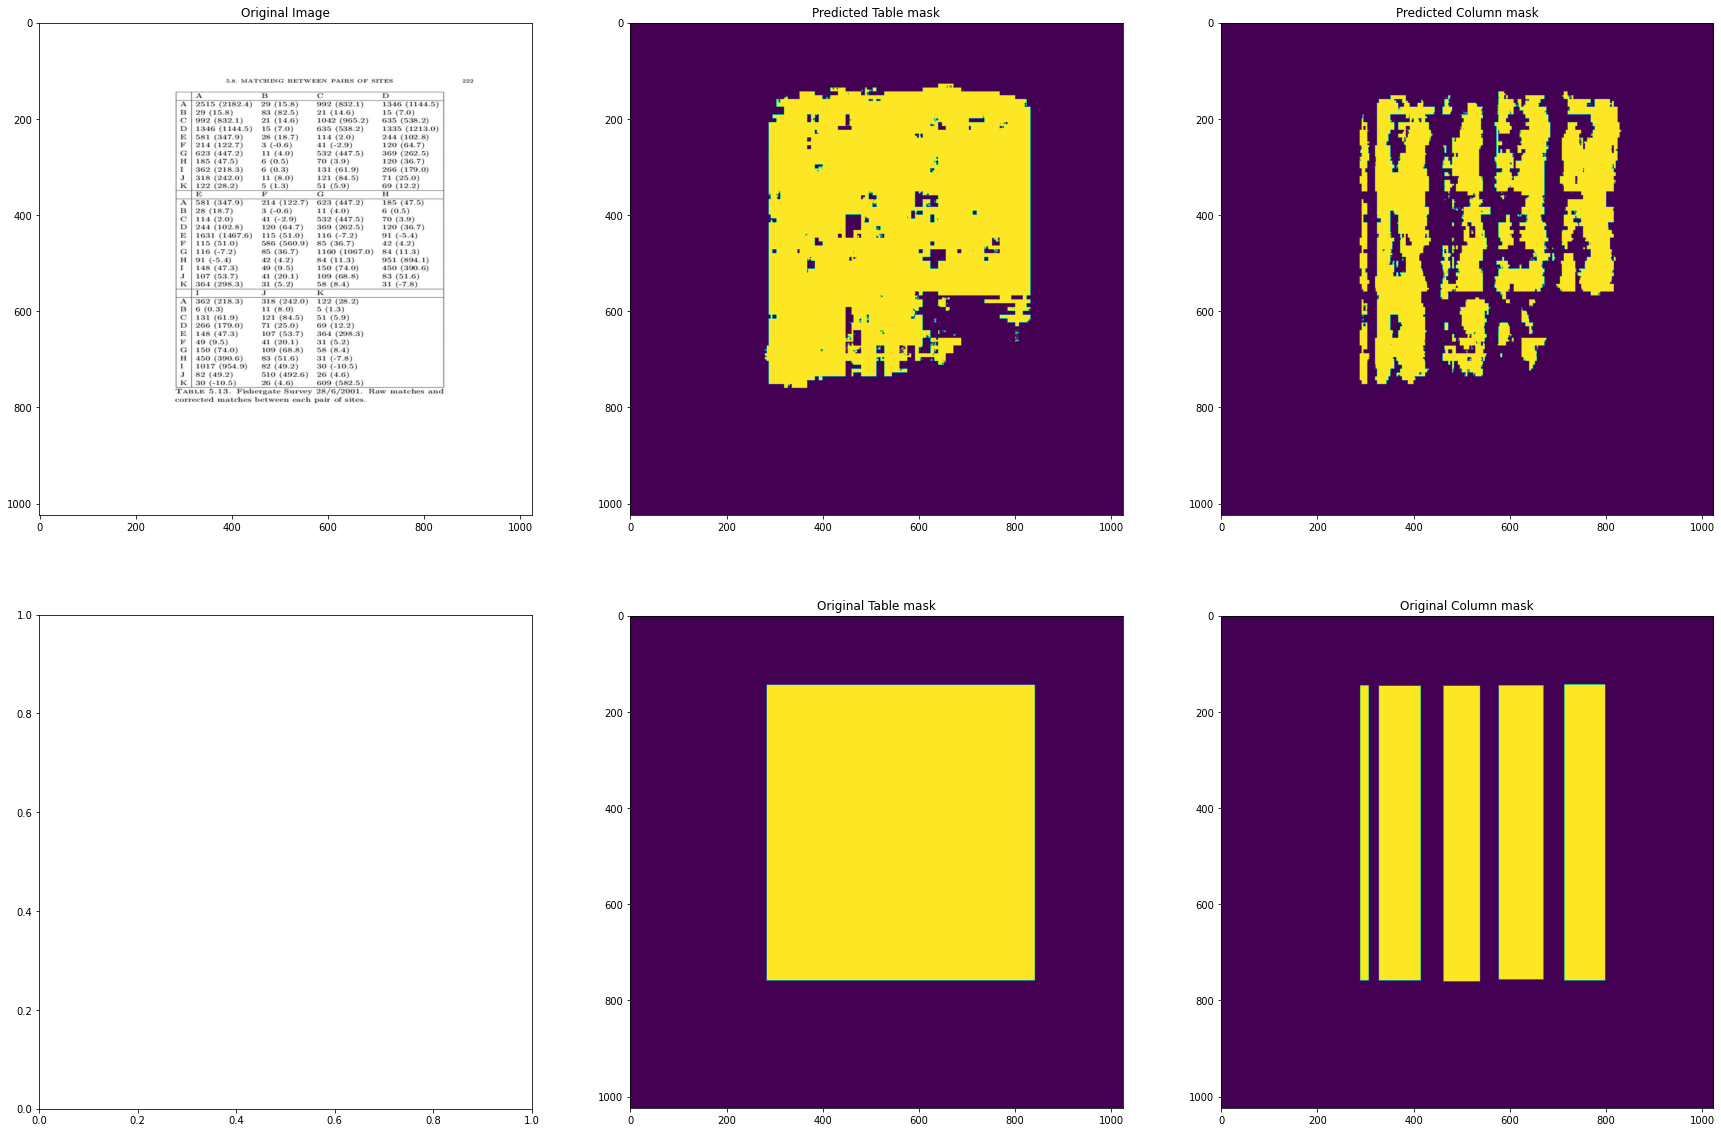

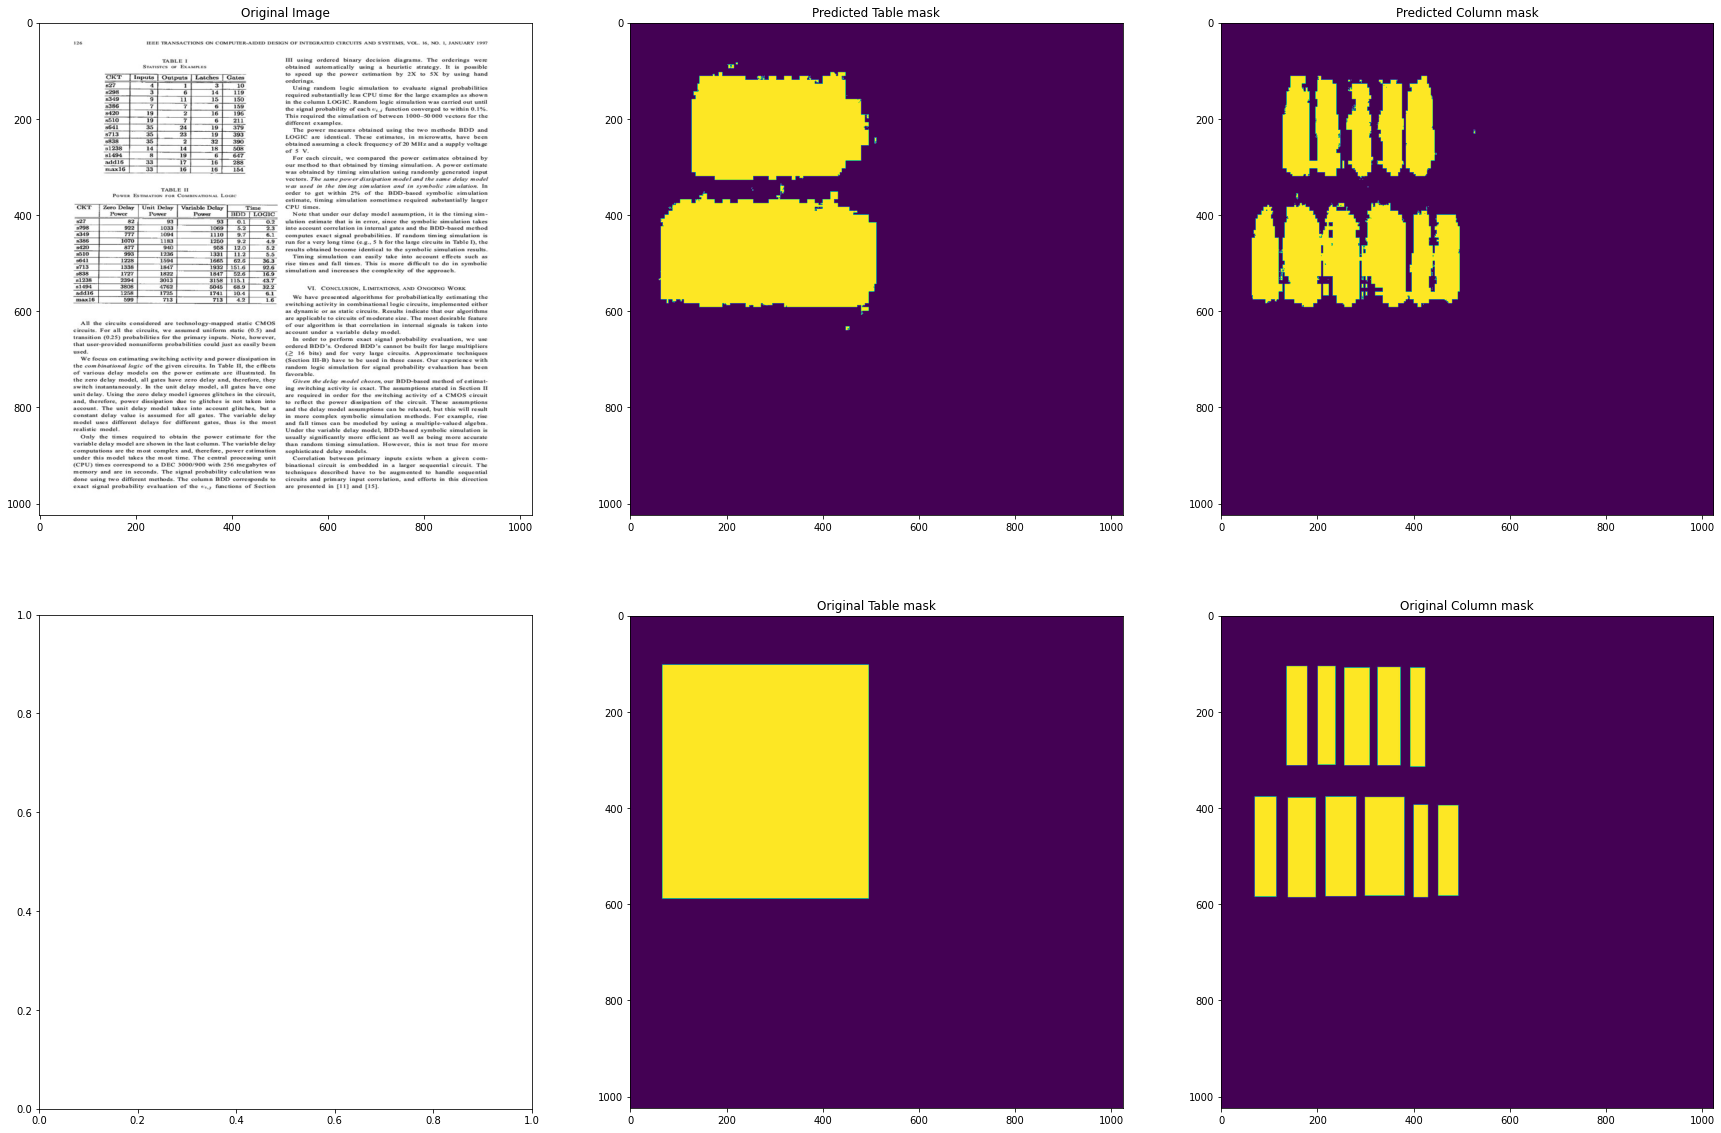

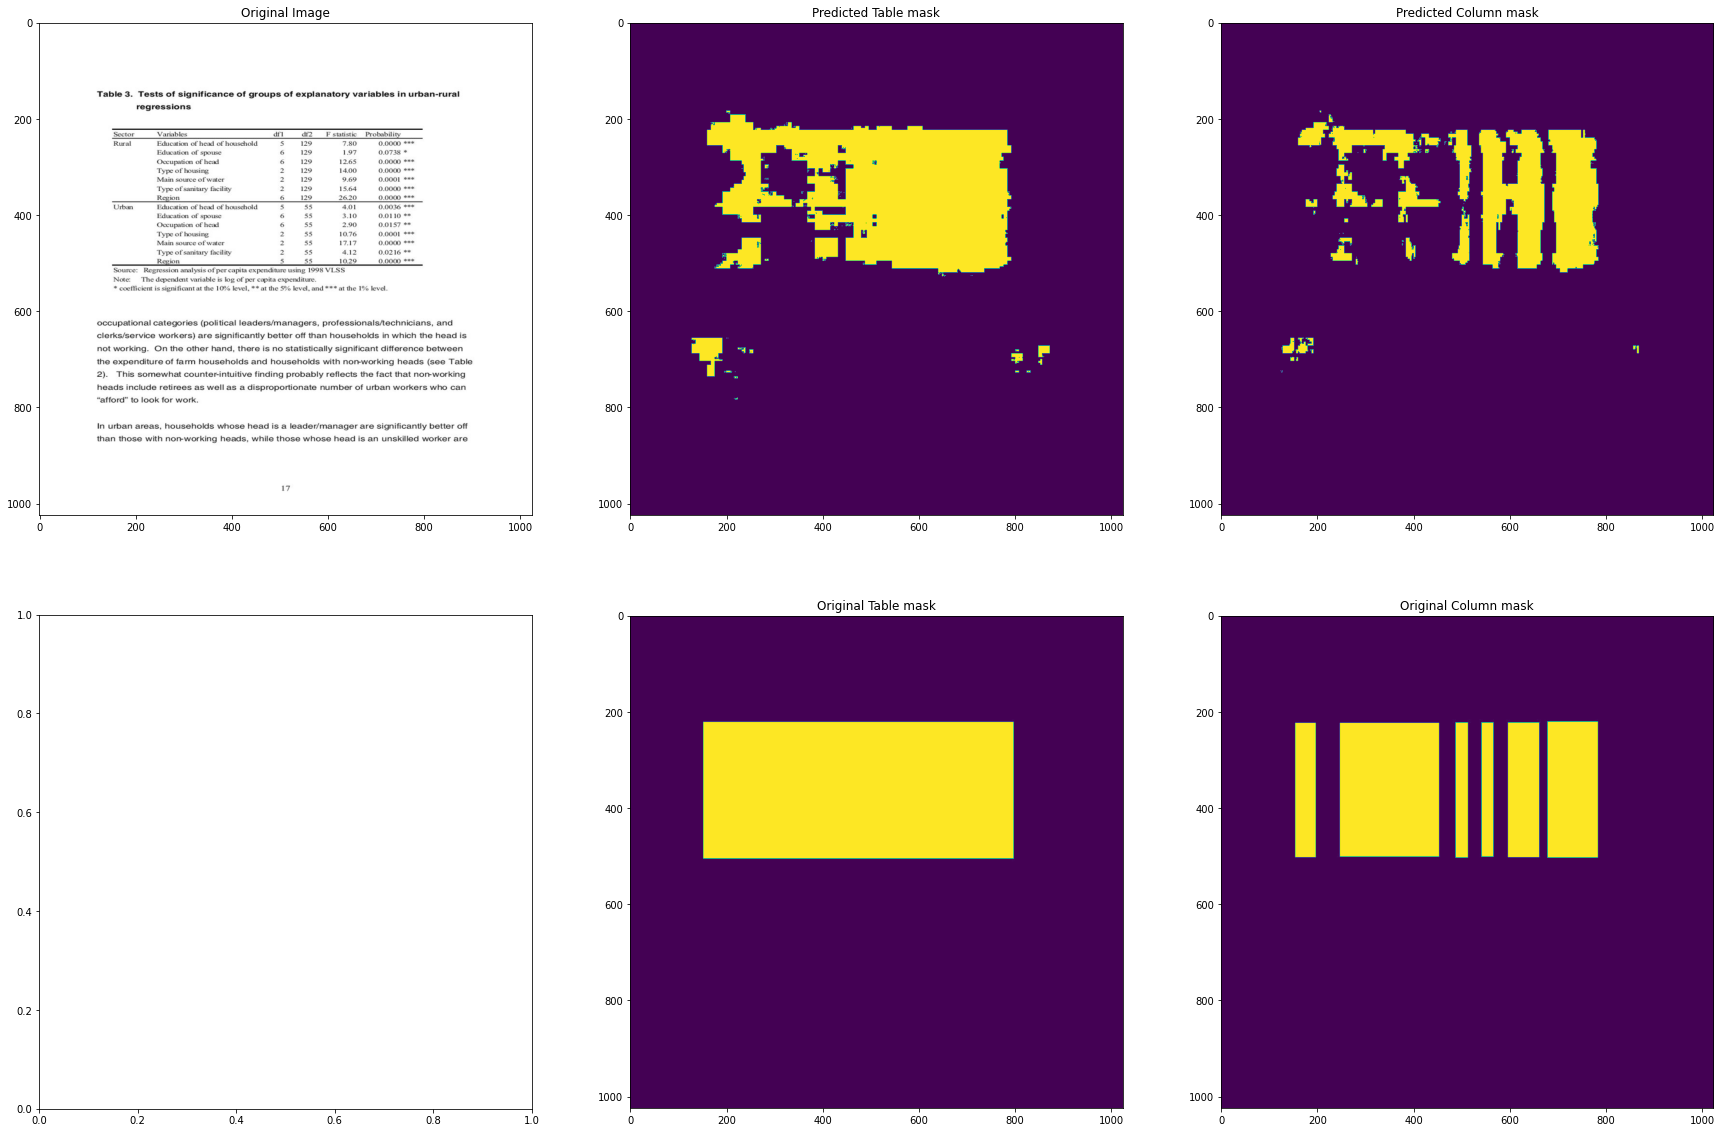

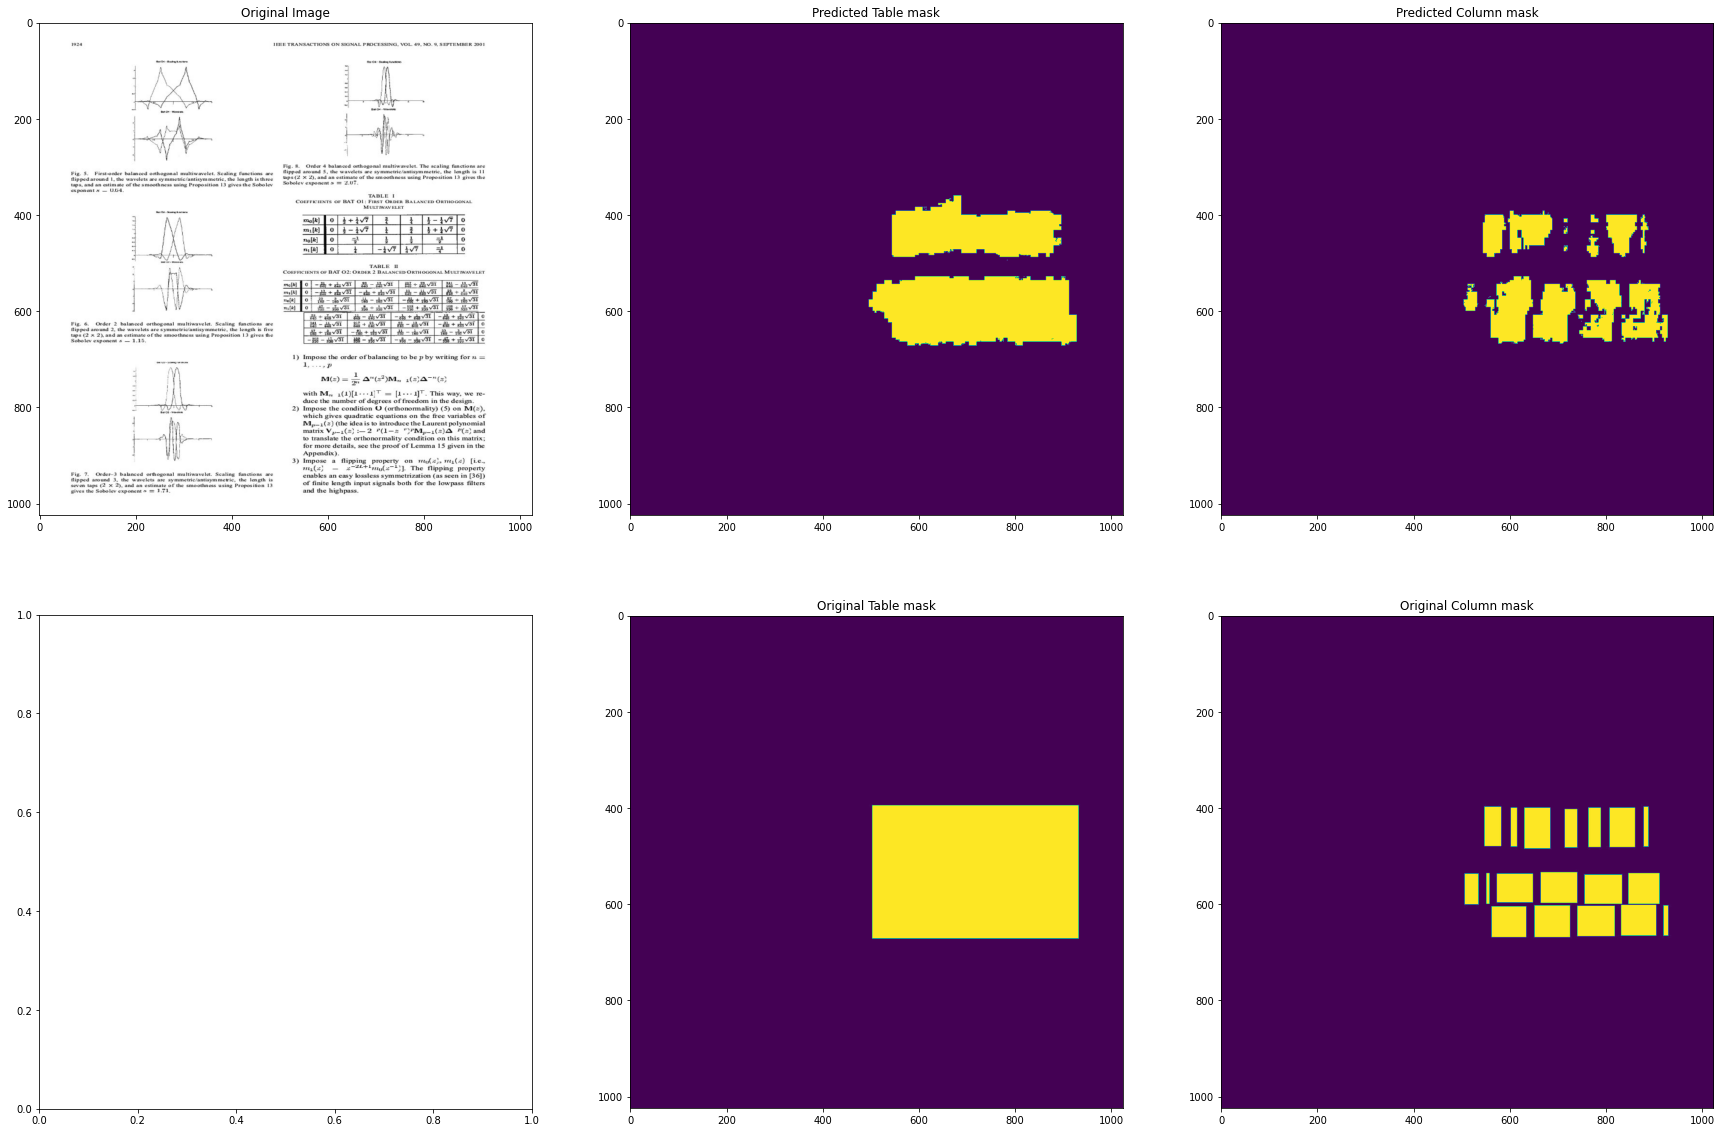

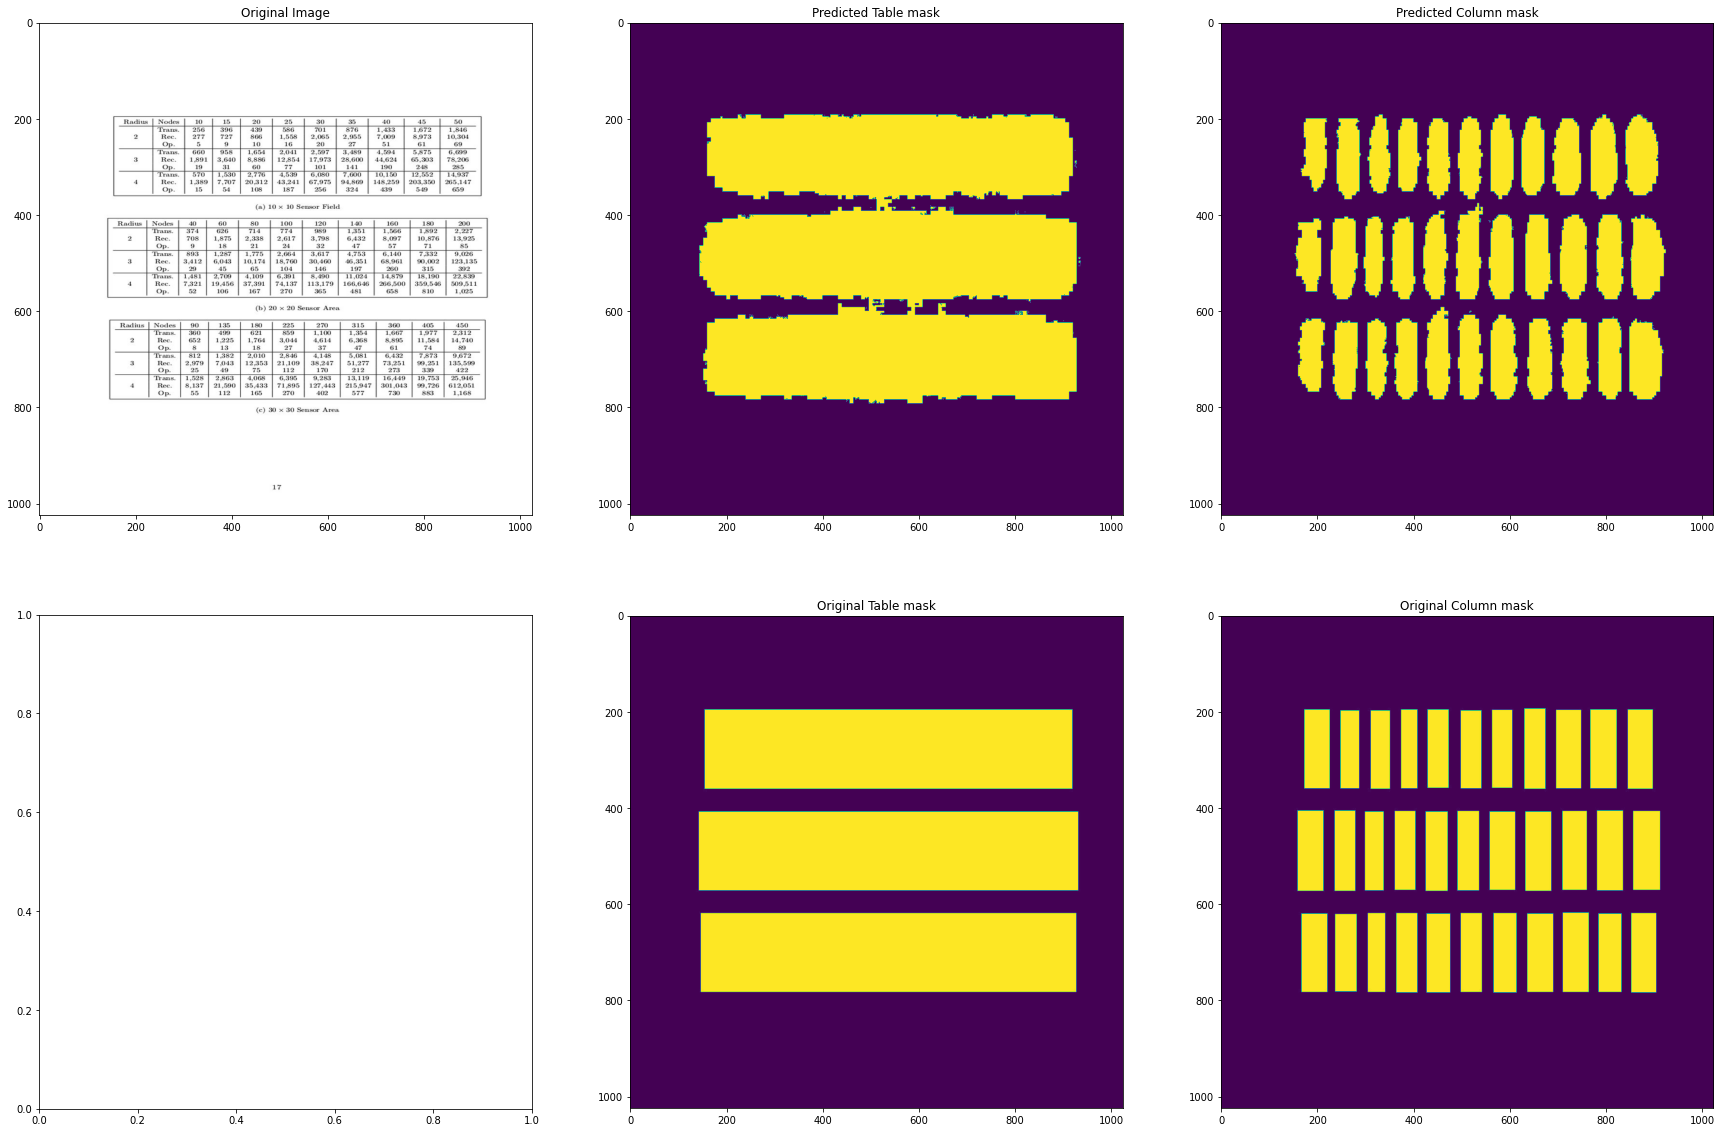

In [40]:
sample_images = ['10.1.1.193.1812_24', '10.1.1.192.1805_60', '10.1.1.178.3008_5', '10.1.1.185.1557_7', '10.1.1.160.686_7',
'10.1.1.160.624_15', '10.1.1.160.538_23', '10.1.1.160.509_17', '10.1.1.120.1603_23', '10.1.1.100.2013_24', 
'10.1.1.100.2026_8', '10.1.1.34.3224_4', '10.1.1.20.2130_26', '10.1.1.7.2189_4', '10.1.1.6.2336_18', 
'10.1.1.1.2134_223', '10.1.1.1.2129_6', '10.1.1.1.2087_26', '10.1.1.1.2044_7', '10.1.1.1.2036_17']

for images in sample_images:
    image_path = 'marmot_preprocessed/'+'image/'+images+'.jpeg'
    visualize_predictions(model_dense, image_path)

# Testing the model with sample invoice images

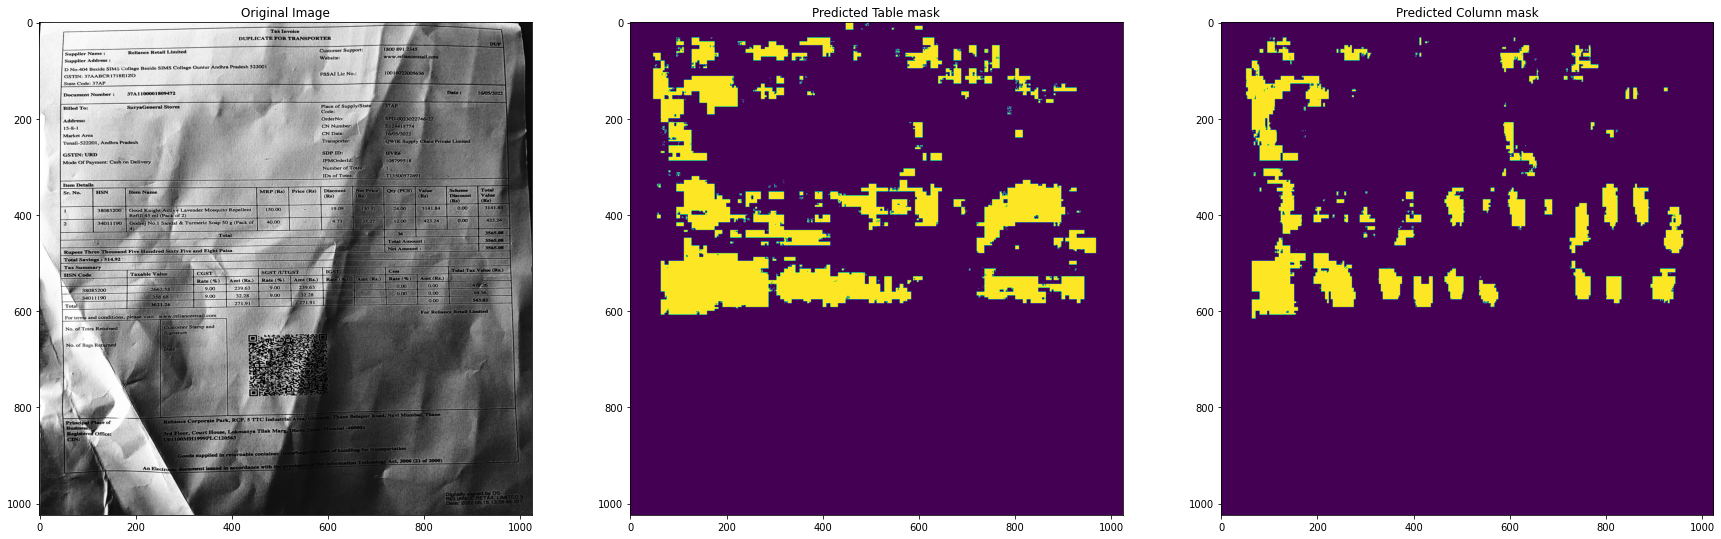

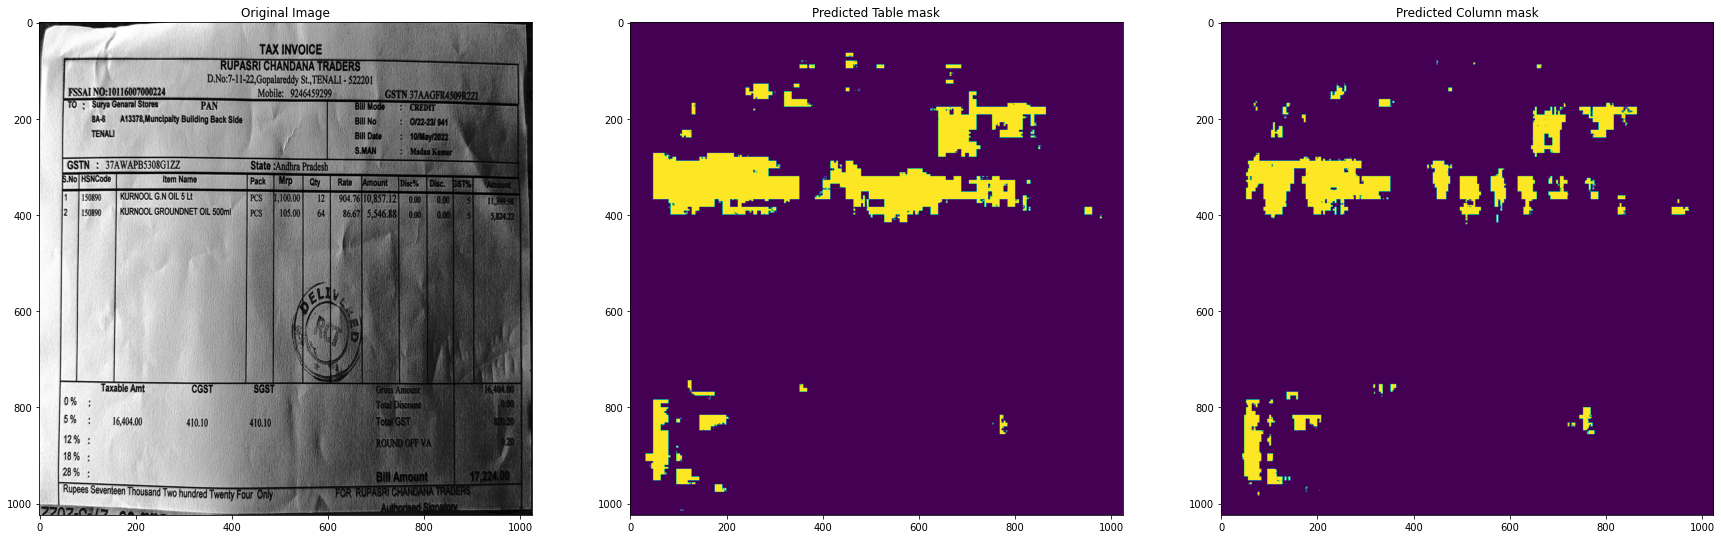

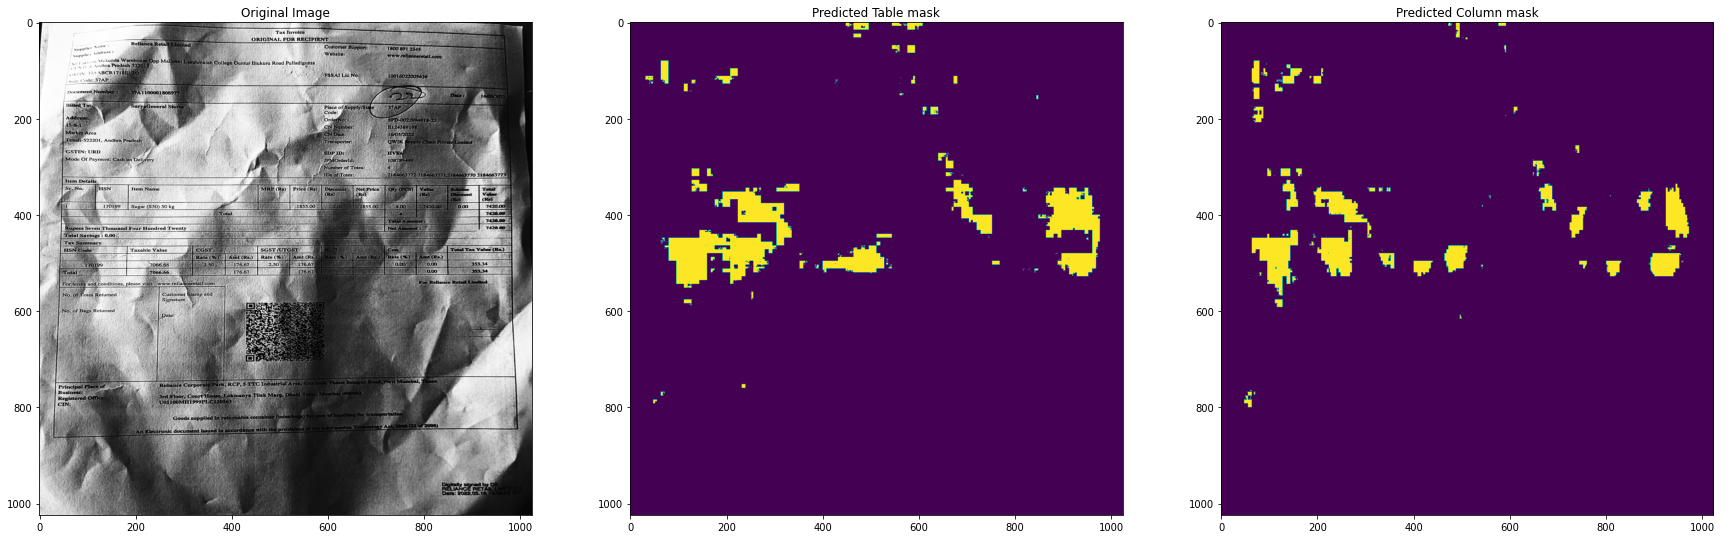

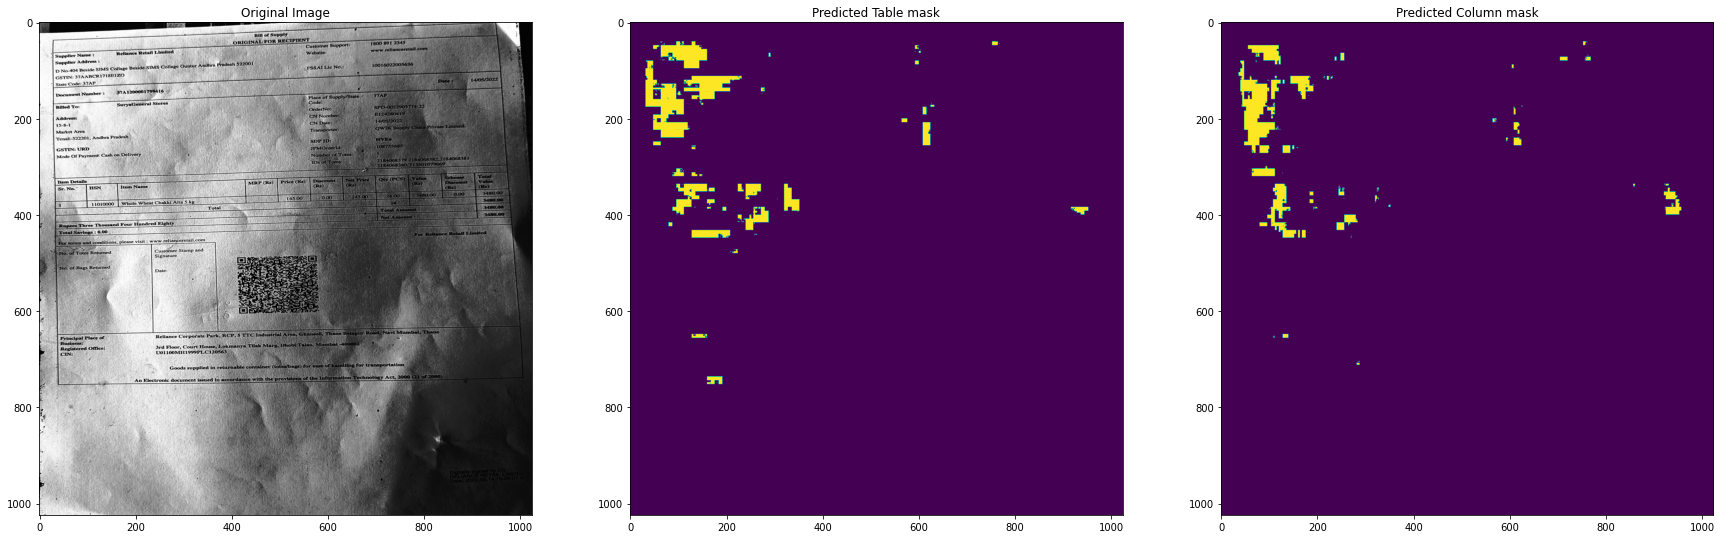

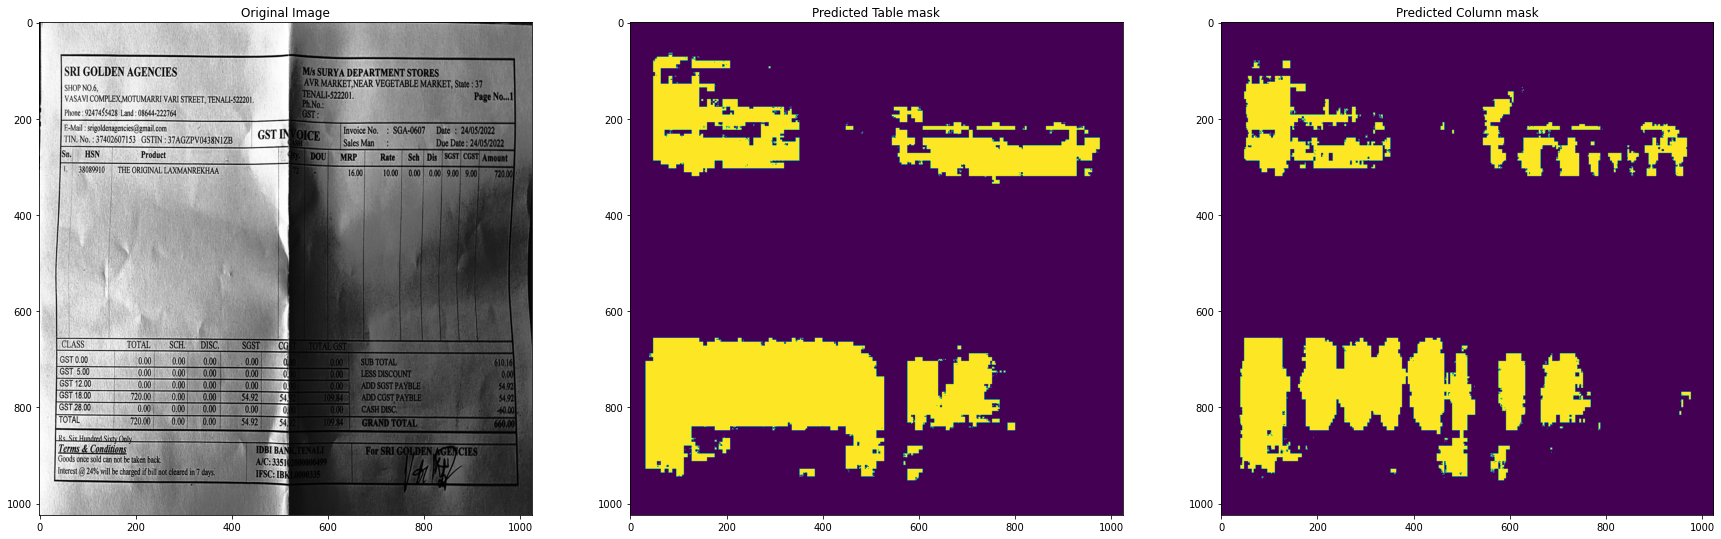

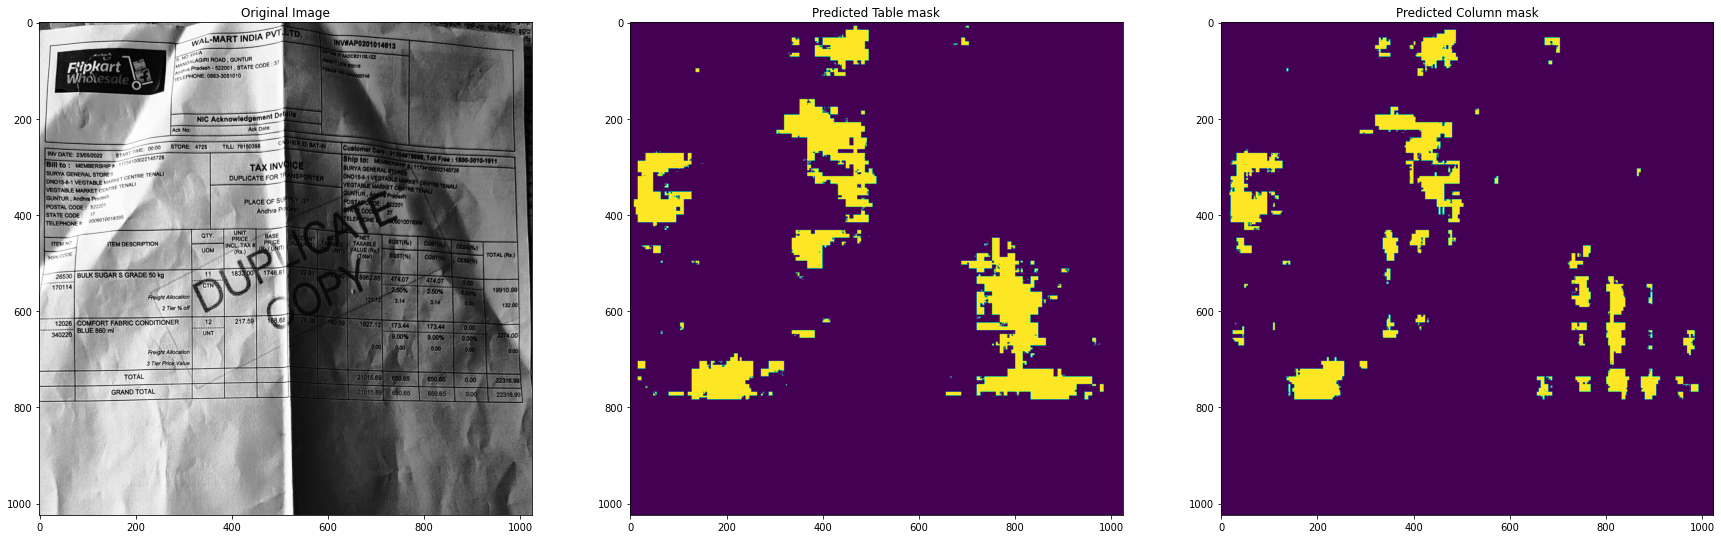

In [41]:
sample_list = os.listdir('../input/kagbbscase-study-2sample-data')

for path in sample_list:
    visualize_predictions(model_dense, '../input/kagbbscase-study-2sample-data/'+path, preprocessing=True)